# Test 

### Feature selection

In [1]:
columns_selection = ['userId', 'time', 'page', 'registration', 'sessionId',
              'itemInSession']

In [2]:
df_test = df_train_test[columns_selection]

NameError: name 'df_train_test' is not defined

### Function

In [ ]:
def create_features_test(df_test, lookback_days=15):
    """
    Creates features for test/production data (NO LABELS).
    Same logic as V4 but without will_churn_10days.
    """
    
    print("Starting feature engineering for TEST data (no labels)...")
    
    # Copy and optimize data types
    df = df_test.copy()
    
    print("Optimizing data types...")
    df['userId'] = df['userId'].astype('category')
    df['page'] = df['page'].astype('category')
    
    print(f"Dataset size: {len(df):,} logs")
    print(f"Users: {df['userId'].nunique():,}, Sessions: {df['sessionId'].nunique():,}")
    
    # Get session info (NO LABEL)
    print("Extracting session information...")
    df_sorted = df.sort_values(['sessionId', 'time'])
    session_info = df_sorted.groupby('sessionId', observed=True).agg({
        'userId': 'first',
        'registration': 'first',
        'time': 'first'
    }).reset_index()
    session_info.columns = ['sessionId', 'userId', 'registration', 'session_start']
    
    # Pre-compute window boundaries
    session_info['window_start'] = session_info['session_start'] - pd.Timedelta(days=lookback_days)
    session_info['window_end'] = session_info['session_start']
    session_info['days_since_registration'] = (
        (session_info['session_start'] - session_info['registration']).dt.total_seconds() / 86400
    ).clip(lower=0)
    
    print(f"Processing {len(session_info):,} sessions...")
    
    df = df.sort_values(['userId', 'time'])
    all_results = []
    
    for user_id, user_sessions in session_info.groupby('userId', observed=True):
        user_logs = df[df['userId'] == user_id]
        
        if len(user_logs) == 0:
            continue
        
        user_times = user_logs['time'].values
        user_pages = user_logs['page'].values
        user_session_ids = user_logs['sessionId'].values
        user_item_in_session = user_logs['itemInSession'].values if 'itemInSession' in user_logs.columns else None
        
        for session_row in user_sessions.itertuples(index=False):
            session_id = session_row.sessionId
            session_start = session_row.session_start
            registration_date = session_row.registration
            window_start = session_row.window_start
            window_end = session_row.window_end
            days_since_registration = session_row.days_since_registration
            
            # Exclude current session
            exclude_current_session = user_session_ids != session_id
            
            # Window mask
            window_mask = (
                (user_times >= window_start) & 
                (user_times < window_end) & 
                exclude_current_session
            )
            
            window_pages = user_pages[window_mask]
            window_times = user_times[window_mask]
            window_session_ids = user_session_ids[window_mask]
            if user_item_in_session is not None:
                window_item_in_session = user_item_in_session[window_mask]
            else:
                window_item_in_session = None
            
            # Calculate inactivity
            previous_mask = (user_times < window_end) & exclude_current_session
            previous_times = user_times[previous_mask]
            
            if len(previous_times) > 0:
                last_action_time = pd.Timestamp(previous_times[-1])
                hours_since_last_action = (session_start - last_action_time).total_seconds() / 3600
            else:
                hours_since_last_action = (session_start - registration_date).total_seconds() / 3600
            
            # Page counting
            if len(window_pages) > 0:
                unique_pages, page_counts = np.unique(window_pages, return_counts=True)
                page_count_dict = dict(zip(unique_pages, page_counts))
            else:
                page_count_dict = {}
            
            def get_count(page_name):
                return page_count_dict.get(page_name, 0)
            
            total_actions = len(window_pages)
            num_sessions = len(np.unique(window_session_ids)) if total_actions > 0 else 0
            
            # Calculate key metrics
            count_next_song = get_count('NextSong')
            count_thumbs_up = get_count('Thumbs Up')
            
            # Skip rate calculation
            skip_count = 0
            if window_item_in_session is not None and len(window_item_in_session) > 1:
                nextsong_mask = window_pages == 'NextSong'
                nextsong_sessions = window_session_ids[nextsong_mask]
                nextsong_items = window_item_in_session[nextsong_mask]
                
                for sess_id in np.unique(nextsong_sessions):
                    sess_items = nextsong_items[nextsong_sessions == sess_id]
                    if len(sess_items) > 1:
                        diffs = np.diff(sess_items)
                        skip_count += np.sum(diffs > 1)
            
            # Previous week for variation
            previous_week_start = window_start - pd.Timedelta(days=7)
            previous_week_end = window_start
            
            previous_week_mask = (
                (user_times >= previous_week_start) & 
                (user_times < previous_week_end) & 
                exclude_current_session
            )
            
            previous_week_pages = user_pages[previous_week_mask]
            previous_week_actions = len(previous_week_pages)
            
            # Activity variation
            if previous_week_actions > 0:
                activity_variation = ((total_actions - previous_week_actions) / previous_week_actions) * 100
            else:
                activity_variation = 0 if total_actions == 0 else 100
            
            # Music consumption variation
            if len(previous_week_pages) > 0:
                prev_unique, prev_counts = np.unique(previous_week_pages, return_counts=True)
                prev_dict = dict(zip(prev_unique, prev_counts))
                previous_week_songs = prev_dict.get('NextSong', 0)
            else:
                previous_week_songs = 0
            
            if previous_week_songs > 0:
                music_consumption_variation = ((count_next_song - previous_week_songs) / previous_week_songs) * 100
            else:
                music_consumption_variation = 0 if count_next_song == 0 else 100
            
            # Features (NO LABEL)
            features = {
                'sessionId': session_id,
                'userId': str(user_id),
                'session_start': session_start,
                'registration': registration_date,
                
                # Temporal
                'hours_since_last_action': hours_since_last_action,
                'days_since_registration': days_since_registration,
                
                # Actions
                'count_help': get_count('Help'),
                'count_about': get_count('About'),
                'count_error': get_count('Error'),
                'count_thumbs_down': get_count('Thumbs Down'),
                'count_add_friend': get_count('Add Friend'),
                'count_settings': get_count('Settings'),
                'count_save_settings': get_count('Save Settings'),
                'count_downgrade': get_count('Downgrade'),
                'count_upgrade': get_count('Upgrade'),
                'count_submit_downgrade': get_count('Submit Downgrade'),
                'count_submit_upgrade': get_count('Submit Upgrade'),
                'count_roll_advert': get_count('Roll Advert'),
                
                # Global
                'total_actions': total_actions,
                'num_sessions': num_sessions,
                
                # Key ratios
                'skip_rate': skip_count / count_next_song if count_next_song > 0 else 0,
                'like_ratio': count_thumbs_up / count_next_song if count_next_song > 0 else 0,
                
                # Variations
                'activity_variation_pct': activity_variation,
                'music_consumption_variation_pct': music_consumption_variation,
                'previous_week_actions': previous_week_actions,
                
                # Flags
                'has_downgrade_action': int(get_count('Downgrade') + get_count('Submit Downgrade') > 0),
                'has_upgrade_action': int(get_count('Upgrade') + get_count('Submit Upgrade') > 0),
                'has_negative_engagement': int(get_count('Thumbs Down') > 0),
            }
            
            all_results.append(features)
    
    print("Creating final dataframe...")
    df_features = pd.DataFrame(all_results)
    df_features = df_features.set_index('sessionId')
    
    print(f"\n✓ Final dataset: {len(df_features):,} rows, {len(df_features.columns) - 3} features")
    
    return df_features


In [ ]:
df_test_features = create_features_test(df_test, lookback_days=60)

Starting feature engineering for TEST data (no labels)...
Optimizing data types...
Dataset size: 4,393,179 logs
Users: 2,904, Sessions: 145,863
Extracting session information...
Processing 145,863 sessions...


KeyboardInterrupt: 

### Predict

In [ ]:
def predict_churn(model, df_test_features):
    """
    Predict churn on test data using trained model.
    
    Parameters:
    -----------
    model : trained RandomForestClassifier
        Model from random_forest_training()
    df_test_features : pd.DataFrame
        Output from create_features_test()
    
    Returns:
    --------
    pd.DataFrame with predictions
    """
    
    # Prepare features (same as training)
    feature_cols = [col for col in df_test_features.columns 
                   if col not in ['userId', 'session_start', 'registration']]
    
    X_test = df_test_features[feature_cols].fillna(0)
    
    print(f"Predicting on {len(X_test):,} sessions...")
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Create results dataframe
    results = df_test_features[['userId', 'session_start', 'registration']].copy()
    results['predicted_churn'] = y_pred
    results['churn_probability'] = y_pred_proba
    
    print(f"\nPredictions:")
    print(f"  Will churn (1): {(y_pred == 1).sum():,} ({(y_pred == 1).sum()/len(y_pred)*100:.1f}%)")
    print(f"  No churn (0):   {(y_pred == 0).sum():,} ({(y_pred == 0).sum()/len(y_pred)*100:.1f}%)")
    
    print(f"\nAverage churn probability: {y_pred_proba.mean():.3f}")
    print(f"High risk (prob > 0.7): {(y_pred_proba > 0.7).sum():,}")
    
    return results

In [ ]:
# Usage:
# 1. Train model
model = random_forest_training(df_train_features)

# 2. Create test features
df_test_features = create_features_test(df_test, lookback_days=15)

# 3. Predict
predictions = predict_churn(model, df_test_features)

# 4. View results
print(predictions.head())
predictions.to_csv('churn_predictions.csv')

# Train

The competition is to be performed in groups of two. You'll have a report of 4 pages to submit by december 14th, presenting the methods you tested and used. For the defense you'll get 8 minutes of presentations + 7 minutes of questions, including on question on the labs, that may involve writing a code snippet.


Churn prediction 25/26
**Predict churn prediction from streaming service logs**

The goal of the competition is to predict whether or not some users (whose user ids are in the test file) will **churn in the window of 10 days that follows the given observations (ie after "2018-11-20")**. We consider that a user churns when they visit the page **'Cancellation Confirmation'** (edited) 


In [ ]:
import pandas as pd

df_train_test = pd.read_parquet("data/test.parquet")
df_train = pd.read_parquet("data/train.parquet")

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17499636 entries, 0 to 25661583
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   status         int64         
 1   gender         object        
 2   firstName      object        
 3   level          object        
 4   lastName       object        
 5   userId         object        
 6   ts             int64         
 7   auth           object        
 8   page           object        
 9   sessionId      int64         
 10  location       object        
 11  itemInSession  int64         
 12  userAgent      object        
 13  method         object        
 14  length         float64       
 15  song           object        
 16  artist         object        
 17  time           datetime64[us]
 18  registration   datetime64[us]
dtypes: datetime64[us](2), float64(1), int64(4), object(12)
memory usage: 2.6+ GB


In [ ]:
# Creating cancellation in following ten days column

import numpy as np

cancellation_events = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
cancellation_events = cancellation_events[['userId', 'time']].rename(columns={'time': 'churn_time'})

df_train = df_train.merge(cancellation_events, on='userId', how='left')

df_train['days_until_churn'] = (df_train['churn_time'] - df_train['time']).dt.total_seconds() / (24 * 3600)

df_train['will_churn_10days'] = ((df_train['days_until_churn'] >= 0) & 
                                   (df_train['days_until_churn'] <= 10)).astype(int)

df_train = df_train.drop(['churn_time', 'days_until_churn'], axis=1)

In [ ]:
df_train.describe() #max time is 2018-11-20 so we are going to keep only the rows that are at least 10 days old OR that have churn True

df_train = df_train[(df_train["time"] < "2018-11-10" )| (df_train["will_churn_10days"] == 1)]

In [ ]:
# create a dataset for free users and paying users

df_train_free = df_train[df_train["level"] == "free"].copy()
df_train_paid = df_train[df_train["level"] == "paid"].copy()

In [ ]:
df_train_paid.sample(10)

users_free = df_train_free["userId"]
users_paid = df_train_paid["userId"]

overlap = users_free[users_free.isin(users_paid)]
print(f"Number of overlapping users: {overlap.nunique()}")
print(f"Total number of users {df_train["userId"].nunique()}")


#Lots of users that switch from free to paid 

Number of overlapping users: 9244
Total number of users 18884


In [ ]:
#Checking that code worked as expected
df_train.sort_values(by='time', ascending = True).head(10)

#!!!!!!!
# Since we only keep rows that have churn True in the last 10 days, our model could learn that a later date means more chance to churn! MERDE


,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration,will_churn_10days
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21,0
15193945,200,M,Austen,free,Horton,1484921,1538352001000,Logged In,NextSong,2436,"New York-Newark-Jersey City, NY-NJ-PA",73,"""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",PUT,238.54975,Just Dance,Lady GaGa / Colby O'Donis,2018-10-01 00:00:01,2018-09-16 09:11:42,0
15194608,200,M,Jose,free,Goodman,1694515,1538352001000,Logged In,NextSong,2466,"Lafayette, LA",1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,231.65342,Give It Up (Album Version),The Format,2018-10-01 00:00:01,2018-09-15 04:03:02,0
1796,200,F,Vina,paid,Bailey,1697168,1538352002000,Logged In,NextSong,4593,"Hilo, HI",109,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,PUT,140.35546,Baby Talk,Lush,2018-10-01 00:00:02,2018-09-08 13:48:25,0
1223,200,F,Vianney,paid,Miller,1563081,1538352002000,Logged In,NextSong,20836,"San Francisco-Oakland-Hayward, CA",9,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,238.39302,MiÃÂ©ntele,Los Bunkers,2018-10-01 00:00:02,2018-09-21 03:25:18,0
15195378,200,F,Noeli,free,Harrison,1379661,1538352003000,Logged In,NextSong,133,"Dallas-Fort Worth-Arlington, TX",140,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,241.24036,All Along The Watchtower,Jimi Hendrix,2018-10-01 00:00:03,2018-07-26 17:36:54,0
15198031,200,F,Samantha,paid,Villanueva,1252007,1538352003000,Logged In,Home,3935,"Fort Collins, CO",36,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,GET,NaN,None,None,2018-10-01 00:00:03,2018-07-19 15:35:33,0
5924,200,F,Aaliyah,paid,Ramirez,1714398,1538352003000,Logged In,NextSong,22316,"Baltimore-Columbia-Towson, MD",21,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,1121.25342,Close To The Edge (I. The Solid Time Of Change...,Yes,2018-10-01 00:00:03,2018-09-19 18:23:35,0
3761,200,M,Andres,paid,Foley,1222580,1538352003000,Logged In,NextSong,6370,"Watertown, SD",71,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,277.15873,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,2018-10-01 00:00:03,2018-08-16 02:31:00,0
15195379,307,F,Noeli,free,Harrison,1379661,1538352004000,Logged In,Logout,133,"Dallas-Fort Worth-Arlington, TX",141,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,NaN,None,None,2018-10-01 00:00:04,2018-07-26 17:36:54,0


In [ ]:
df_train.describe()

,status,ts,sessionId,itemInSession,length,time,registration,will_churn_10days
count,1.465755e+07,1.465755e+07,1.465755e+07,1.465755e+07,1.195098e+07,14657548,14657548,1.465755e+07
mean,2.091415e+02,1.540076e+12,7.294373e+04,1.045211e+02,2.487060e+02,2018-10-20 22:51:07.219720,2018-08-25 02:18:34.093644,1.235250e-01
min,2.000000e+02,1.538352e+12,1.000000e+00,0.000000e+00,5.220000e-01,2018-10-01 00:00:01,2017-10-14 22:05:25,0.000000e+00
25%,2.000000e+02,1.539193e+12,2.127200e+04,2.500000e+01,1.998624e+02,2018-10-10 17:35:49.750000,2018-08-10 22:00:31,0.000000e+00
50%,2.000000e+02,1.540025e+12,6.789700e+04,6.500000e+01,2.340828e+02,2018-10-20 08:43:09,2018-09-05 15:53:20,0.000000e+00
75%,2.000000e+02,1.540941e+12,1.190990e+05,1.420000e+02,2.768714e+02,2018-10-30 23:12:18,2018-09-20 15:27:40,0.000000e+00
max,4.040000e+02,1.542672e+12,2.047110e+05,1.426000e+03,3.024666e+03,2018-11-19 23:55:09,2018-11-14 23:31:27,1.000000e+00
std,3.023523e+01,1.020072e+09,5.300614e+04,1.165782e+02,9.725864e+01,NaN,NaN,3.290388e-01


In [ ]:
# We add columns that could be explanatory
df_train['hour'] = df_train['time'].dt.hour
df_train['month'] = df_train['time'].dt.month

## Preliminary EDA

In [ ]:
numerical_columns = ['ts', 'itemInSession', 'status', 'length','hour', 'month']
categorical_columns = ['auth', 'page', 'location', 'userAgent',
                       'method', 'song', 'artist']
target_column = ['will_churn_10days']
time_columns = ['time', 'registration']
all_columns = numerical_columns + categorical_columns + target_column + time_columns

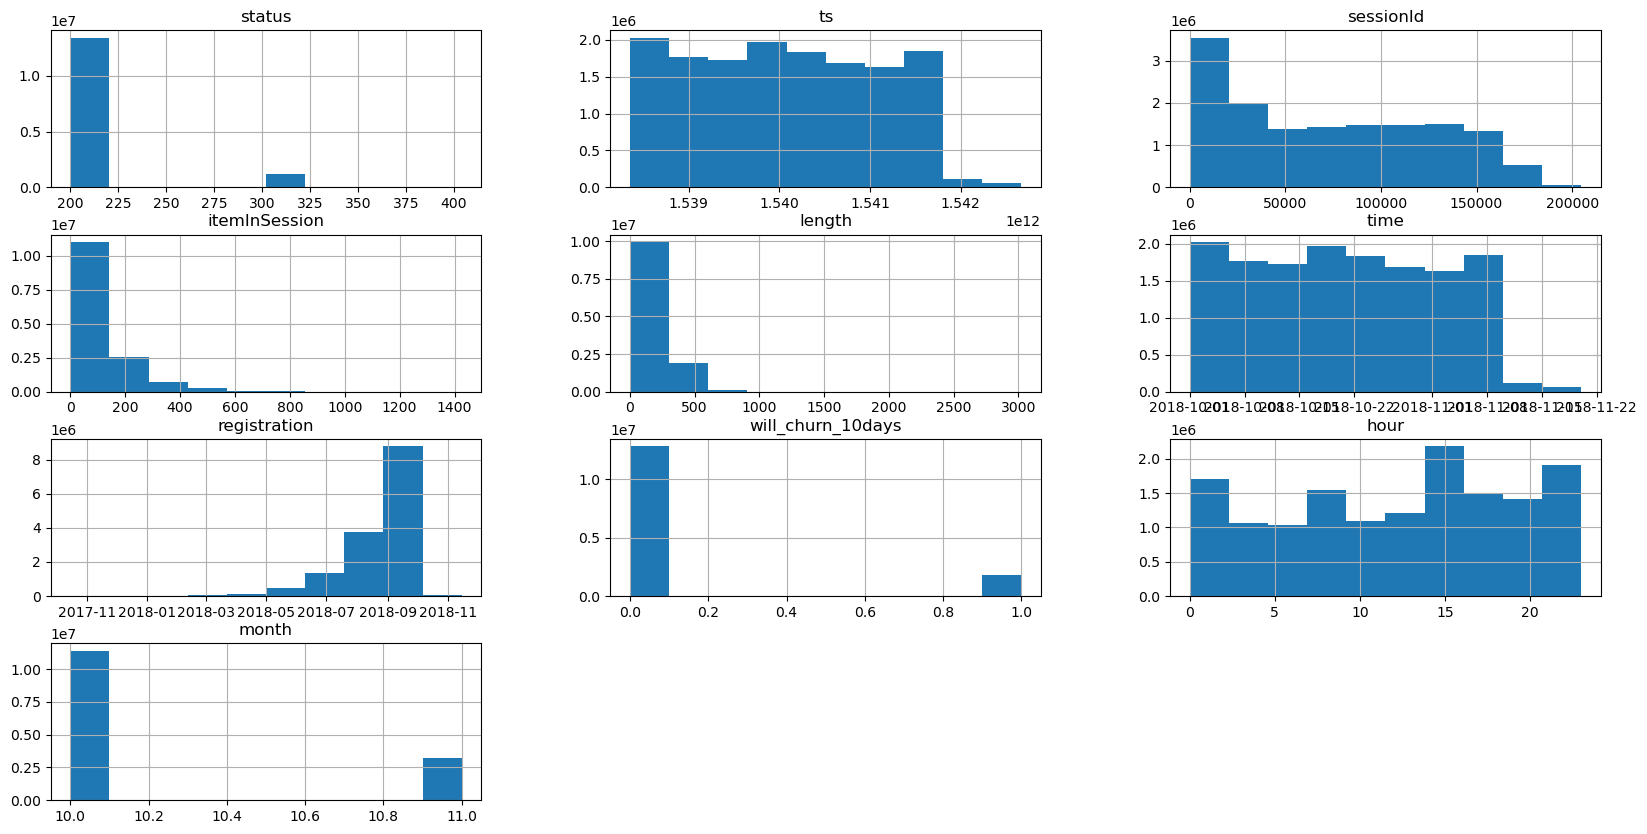

In [ ]:
df_train.hist(figsize=(20, 10)); 

In [ ]:
unique_counts = df_train.nunique()

print(unique_counts)

status                     3
gender                     2
firstName               4930
level                      2
lastName                1000
userId                 18884
ts                   3521777
auth                       2
page                      19
sessionId             137694
location                 875
itemInSession           1427
userAgent                 85
method                     2
length                 23169
song                  232003
artist                 36716
time                 3521777
registration           18862
will_churn_10days          2
hour                      24
month                      2
dtype: int64


In [ ]:
df_train['itemInSession'].value_counts()

itemInSession
2       164595
3       163243
4       161394
5       158941
6       156489
         ...  
1374         2
1373         2
1328         2
1425         1
1426         1
Name: count, Length: 1427, dtype: int64

In [ ]:
df_train['auth'].value_counts()

auth
Logged In    14653277
Cancelled        4271
Name: count, dtype: int64

In [ ]:
df_train['page'].unique()

array(['NextSong', 'Downgrade', 'Help', 'Home', 'Thumbs Up', 'Add Friend',
       'Thumbs Down', 'Add to Playlist', 'Logout', 'About', 'Settings',
       'Save Settings', 'Cancel', 'Cancellation Confirmation',
       'Submit Downgrade', 'Roll Advert', 'Upgrade', 'Error',
       'Submit Upgrade'], dtype=object)

In [ ]:
df_train['page'].value_counts()

page
NextSong                     11950984
Thumbs Up                      657936
Home                           543452
Add to Playlist                341986
Roll Advert                    253569
Add Friend                     219631
Logout                         172674
Thumbs Down                    139064
Downgrade                      103258
Settings                        84952
Help                            74615
Upgrade                         33542
About                           27807
Save Settings                   17069
Error                           14512
Submit Upgrade                  10215
Cancellation Confirmation        4271
Cancel                           4271
Submit Downgrade                 3740
Name: count, dtype: int64

## Feature preprocessing

In [ ]:
# Sampling the dataset to try the functions:
sample_users = df_train['userId'].drop_duplicates().sample(n=1000, random_state=42)
sample_df_train = df_train[df_train['userId'].isin(sample_users)].copy()

In [ ]:
# Selection of columns to simplify the dataset
columns_selection = ['userId', 'time', 'page', 'registration', 'sessionId',
              'itemInSession', 'will_churn_10days']
sample_df_train = sample_df_train[columns_selection]
sample_df_train.sample(10)

,userId,time,page,registration,sessionId,itemInSession,will_churn_10days
2057100,1554108,2018-10-26 06:07:28,NextSong,2018-09-21 01:28:00,124264,89,0
11094373,1691079,2018-11-01 06:45:33,NextSong,2018-07-28 12:37:10,130014,27,0
10340535,1907518,2018-10-22 20:40:02,NextSong,2018-09-26 08:14:01,68631,51,0
305280,1446439,2018-10-29 18:30:31,NextSong,2018-08-20 17:49:37,131674,143,0
10770060,1976556,2018-10-25 11:44:44,NextSong,2018-07-13 14:21:41,108057,113,0
659012,1920313,2018-10-16 13:07:47,NextSong,2018-09-19 09:07:58,80649,619,0
12111699,1253989,2018-10-19 13:49:07,Upgrade,2018-09-13 15:00:12,88632,23,0
6794361,1921215,2018-10-02 10:14:18,NextSong,2018-08-31 19:42:49,7831,62,0
4140699,1199654,2018-10-17 22:15:43,Home,2018-08-18 03:21:01,90598,53,0
10325033,1298544,2018-10-22 17:22:28,NextSong,2018-09-05 21:45:32,91728,57,0


### Optimized function

### Current function

In [ ]:
def create_featuresV4(df_train, lookback_days=15, batch_size=1000):
    """
    Creates aggregated features for churn prediction (V4 - CLEANED VERSION).
    Removed redundant/low-importance features from V3.
    """
    
    print("Starting feature engineering V4 (cleaned version)...")
    
    # Copy and optimize data types
    df = df_train.copy()
    
    print("Optimizing data types...")
    df['userId'] = df['userId'].astype('category')
    df['page'] = df['page'].astype('category')
    
    print(f"Dataset size: {len(df):,} logs")
    print(f"Users: {df['userId'].nunique():,}, Sessions: {df['sessionId'].nunique():,}")
    
    # Get session info
    print("Extracting session information...")
    df_sorted = df.sort_values(['sessionId', 'time'])
    session_info = df_sorted.groupby('sessionId', observed=True).agg({
        'userId': 'first',
        'registration': 'first',
        'time': 'first',
        'will_churn_10days': 'first'
    }).reset_index()
    session_info.columns = ['sessionId', 'userId', 'registration', 'session_start', 'will_churn_10days']
    
    # Pre-compute window boundaries
    session_info['window_start'] = session_info['session_start'] - pd.Timedelta(days=lookback_days)
    session_info['window_end'] = session_info['session_start']
    session_info['days_since_registration'] = (
        (session_info['session_start'] - session_info['registration']).dt.total_seconds() / 86400
    ).clip(lower=0)
    
    print(f"Processing {len(session_info):,} sessions in batches of {batch_size} users...")
    
    unique_users = session_info['userId'].unique()
    n_batches = int(np.ceil(len(unique_users) / batch_size))
    all_results = []
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(unique_users))
        batch_users = unique_users[start_idx:end_idx]
        
        batch_df = df[df['userId'].isin(batch_users)].copy()
        batch_sessions = session_info[session_info['userId'].isin(batch_users)].copy()
        batch_df = batch_df.sort_values(['userId', 'time'])
        
        batch_results = []
        
        for user_id, user_sessions in batch_sessions.groupby('userId', observed=True):
            user_logs = batch_df[batch_df['userId'] == user_id]
            
            if len(user_logs) == 0:
                continue
            
            user_times = user_logs['time'].values
            user_pages = user_logs['page'].values
            user_session_ids = user_logs['sessionId'].values
            user_item_in_session = user_logs['itemInSession'].values if 'itemInSession' in user_logs.columns else None
            
            for session_row in user_sessions.itertuples(index=False):
                session_id = session_row.sessionId
                session_start = session_row.session_start
                registration_date = session_row.registration
                label = session_row.will_churn_10days
                window_start = session_row.window_start
                window_end = session_row.window_end
                days_since_registration = session_row.days_since_registration
                
                # Exclude current session
                exclude_current_session = user_session_ids != session_id
                
                # Window mask
                window_mask = (
                    (user_times >= window_start) & 
                    (user_times < window_end) & 
                    exclude_current_session
                )
                
                window_pages = user_pages[window_mask]
                window_times = user_times[window_mask]
                window_session_ids = user_session_ids[window_mask]
                if user_item_in_session is not None:
                    window_item_in_session = user_item_in_session[window_mask]
                else:
                    window_item_in_session = None
                
                # Calculate inactivity
                previous_mask = (user_times < window_end) & exclude_current_session
                previous_times = user_times[previous_mask]
                
                if len(previous_times) > 0:
                    last_action_time = pd.Timestamp(previous_times[-1])
                    hours_since_last_action = (session_start - last_action_time).total_seconds() / 3600
                else:
                    hours_since_last_action = (session_start - registration_date).total_seconds() / 3600
                
                # Page counting
                if len(window_pages) > 0:
                    unique_pages, page_counts = np.unique(window_pages, return_counts=True)
                    page_count_dict = dict(zip(unique_pages, page_counts))
                else:
                    page_count_dict = {}
                
                def get_count(page_name):
                    return page_count_dict.get(page_name, 0)
                
                total_actions = len(window_pages)
                num_sessions = len(np.unique(window_session_ids)) if total_actions > 0 else 0
                
                # Calculate key metrics
                count_next_song = get_count('NextSong')
                count_thumbs_up = get_count('Thumbs Up')
                
                # Skip rate calculation
                skip_count = 0
                if window_item_in_session is not None and len(window_item_in_session) > 1:
                    nextsong_mask = window_pages == 'NextSong'
                    nextsong_sessions = window_session_ids[nextsong_mask]
                    nextsong_items = window_item_in_session[nextsong_mask]
                    
                    for sess_id in np.unique(nextsong_sessions):
                        sess_items = nextsong_items[nextsong_sessions == sess_id]
                        if len(sess_items) > 1:
                            diffs = np.diff(sess_items)
                            skip_count += np.sum(diffs > 1)
                
                # Previous week for variation
                previous_week_start = window_start - pd.Timedelta(days=7)
                previous_week_end = window_start
                
                previous_week_mask = (
                    (user_times >= previous_week_start) & 
                    (user_times < previous_week_end) & 
                    exclude_current_session
                )
                
                previous_week_pages = user_pages[previous_week_mask]
                previous_week_actions = len(previous_week_pages)
                
                # Activity variation
                if previous_week_actions > 0:
                    activity_variation = ((total_actions - previous_week_actions) / previous_week_actions) * 100
                else:
                    activity_variation = 0 if total_actions == 0 else 100
                
                # Music consumption variation
                if len(previous_week_pages) > 0:
                    prev_unique, prev_counts = np.unique(previous_week_pages, return_counts=True)
                    prev_dict = dict(zip(prev_unique, prev_counts))
                    previous_week_songs = prev_dict.get('NextSong', 0)
                else:
                    previous_week_songs = 0
                
                if previous_week_songs > 0:
                    music_consumption_variation = ((count_next_song - previous_week_songs) / previous_week_songs) * 100
                else:
                    music_consumption_variation = 0 if count_next_song == 0 else 100
                
                # Features
                features = {
                    'sessionId': session_id,
                    'userId': str(user_id),
                    'session_start': session_start,
                    'registration': registration_date,
                    'will_churn_10days': label,
                    
                    # Temporal
                    'hours_since_last_action': hours_since_last_action,
                    'days_since_registration': days_since_registration,
                    
                    # Actions
                    'count_help': get_count('Help'),
                    'count_about': get_count('About'),
                    'count_error': get_count('Error'),
                    'count_thumbs_down': get_count('Thumbs Down'),
                    'count_add_friend': get_count('Add Friend'),
                    'count_settings': get_count('Settings'),
                    'count_save_settings': get_count('Save Settings'),
                    'count_downgrade': get_count('Downgrade'),
                    'count_upgrade': get_count('Upgrade'),
                    'count_submit_downgrade': get_count('Submit Downgrade'),
                    'count_submit_upgrade': get_count('Submit Upgrade'),
                    'count_roll_advert': get_count('Roll Advert'),
                    
                    # Global
                    'total_actions': total_actions,
                    'num_sessions': num_sessions,
                    
                    # Key ratios
                    'skip_rate': skip_count / count_next_song if count_next_song > 0 else 0,
                    'like_ratio': count_thumbs_up / count_next_song if count_next_song > 0 else 0,
                    
                    # Variations
                    'activity_variation_pct': activity_variation,
                    'music_consumption_variation_pct': music_consumption_variation,
                    'previous_week_actions': previous_week_actions,
                    
                    # Flags
                    'has_downgrade_action': int(get_count('Downgrade') + get_count('Submit Downgrade') > 0),
                    'has_upgrade_action': int(get_count('Upgrade') + get_count('Submit Upgrade') > 0),
                    'has_negative_engagement': int(get_count('Thumbs Down') > 0),
                }
                
                batch_results.append(features)
        
        all_results.extend(batch_results)
        
        if (batch_idx + 1) % 10 == 0 or batch_idx == n_batches - 1:
            print(f"  Processed batch {batch_idx + 1}/{n_batches} ({len(all_results):,} sessions so far)")
    
    print("Creating final dataframe...")
    df_features = pd.DataFrame(all_results)
    df_features = df_features.set_index('sessionId')
    
    print(f"\n✓ Final dataset: {len(df_features):,} rows, {len(df_features.columns) - 4} features")
    print(f"Label distribution:")
    print(df_features['will_churn_10days'].value_counts())
    
    return df_features

### Old versions

In [ ]:
# V3 - Enhanced with new engagement and variation features

import pandas as pd
import numpy as np
from datetime import timedelta


def create_featuresV3(df_train, lookback_days=15, batch_size=1000):
    """
    Creates aggregated features for churn prediction (V3 - ENHANCED VERSION).
    One row is created per session with features calculated on the N previous days.
    
    NEW FEATURES IN V3:
    - Skip rate: number of times user skipped to next song before it finished
    - Like ratio: liked songs / total songs listened
    - Activity variation: change in total actions vs previous week
    - Music consumption variation: change in songs listened vs previous week
    - Positive engagement: combined thumbs up, add friend, add playlist
    - Negative engagement: thumbs down count
    
    IMPORTANT: Features are calculated ONLY on data from BEFORE the current session
    to avoid data leakage. The sliding window is [session_start - lookback_days, session_start[,
    EXCLUDING the current session itself.
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Dataset with columns: userId, time, page, registration, sessionId, 
        itemInSession, will_churn_10days
        - registration: user's subscription date (fixed per user, used as feature)
        - time: timestamp of each log
        - sessionId: unique identifier for each session
        - itemInSession: sequential number of the item in the session (used to detect skips)
    lookback_days : int
        Number of historical days to consider for calculating features
    batch_size : int
        Number of users to process per batch (for memory efficiency)
    
    Returns:
    --------
    pd.DataFrame
        Dataset with aggregated features, one row per session
    """
    
    print("Starting feature engineering V3 (enhanced with new features)...")
    
    # Copy and optimize data types
    df = df_train.copy()
    
    print("Optimizing data types...")
    # Convert to optimal data types
    df['userId'] = df['userId'].astype('category')
    df['page'] = df['page'].astype('category')
    
    print(f"Dataset size: {len(df):,} logs")
    print(f"Users: {df['userId'].nunique():,}, Sessions: {df['sessionId'].nunique():,}")
    
    # Get session info: first log chronologically per session (vectorized)
    print("Extracting session information...")
    df_sorted = df.sort_values(['sessionId', 'time'])
    session_info = df_sorted.groupby('sessionId', observed=True).agg({
        'userId': 'first',
        'registration': 'first',
        'time': 'first',  # Session start = first log time
        'will_churn_10days': 'first'
    }).reset_index()
    session_info.columns = ['sessionId', 'userId', 'registration', 'session_start', 'will_churn_10days']
    
    # Pre-compute window boundaries (vectorized)
    # Sliding window: [session_start - lookback_days, session_start[
    session_info['window_start'] = session_info['session_start'] - pd.Timedelta(days=lookback_days)
    session_info['window_end'] = session_info['session_start']
    
    # Calculate days since registration (ensure non-negative)
    session_info['days_since_registration'] = (
        session_info['session_start'] - session_info['registration']
    ).dt.total_seconds() / 86400  # Convert to days as float
    session_info['days_since_registration'] = session_info['days_since_registration'].clip(lower=0)
    
    print(f"Processing {len(session_info):,} sessions in batches of {batch_size} users...")
    
    # Get unique users and process in batches
    unique_users = session_info['userId'].unique()
    n_batches = int(np.ceil(len(unique_users) / batch_size))
    
    all_results = []
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(unique_users))
        batch_users = unique_users[start_idx:end_idx]
        
        # Filter data for this batch of users
        batch_df = df[df['userId'].isin(batch_users)].copy()
        batch_sessions = session_info[session_info['userId'].isin(batch_users)].copy()
        
        # Sort batch data by userId and time for faster filtering
        batch_df = batch_df.sort_values(['userId', 'time'])
        
        batch_results = []
        
        # Group by userId to process all sessions of a user together
        for user_id, user_sessions in batch_sessions.groupby('userId', observed=True):
            # Get all logs for this user (already sorted)
            user_logs = batch_df[batch_df['userId'] == user_id]
            
            if len(user_logs) == 0:
                continue
            
            # Pre-extract arrays for faster access
            user_times = user_logs['time'].values
            user_pages = user_logs['page'].values
            user_session_ids = user_logs['sessionId'].values
            user_item_in_session = user_logs['itemInSession'].values if 'itemInSession' in user_logs.columns else None
            
            # For each session of this user (using itertuples for better performance)
            for session_row in user_sessions.itertuples(index=False):
                session_id = session_row.sessionId
                session_start = session_row.session_start
                registration_date = session_row.registration
                label = session_row.will_churn_10days
                window_start = session_row.window_start
                window_end = session_row.window_end
                days_since_registration = session_row.days_since_registration
                
                # CRITICAL FIX: Exclude current session to avoid data leakage
                exclude_current_session = user_session_ids != session_id
                
                # Vectorized filtering using numpy for speed
                # Window: [session_start - lookback_days, session_start[ EXCLUDING current session
                window_mask = (
                    (user_times >= window_start) & 
                    (user_times < window_end) & 
                    exclude_current_session
                )
                
                # Get data within the window
                window_pages = user_pages[window_mask]
                window_times = user_times[window_mask]
                window_session_ids = user_session_ids[window_mask]
                if user_item_in_session is not None:
                    window_item_in_session = user_item_in_session[window_mask]
                else:
                    window_item_in_session = None
                
                # Calculate inactivity: time since last action before this session
                # Previous actions: all actions before session_start, excluding current session
                previous_mask = (user_times < window_end) & exclude_current_session
                previous_times = user_times[previous_mask]
                
                if len(previous_times) > 0:
                    # Calculate hours since last action
                    last_action_time = pd.Timestamp(previous_times[-1])
                    hours_since_last_action = (session_start - last_action_time).total_seconds() / 3600
                else:
                    # First session ever: calculate hours since registration
                    hours_since_last_action = (session_start - registration_date).total_seconds() / 3600
                
                # Vectorized page counting using numpy
                if len(window_pages) > 0:
                    unique_pages, page_counts = np.unique(window_pages, return_counts=True)
                    page_count_dict = dict(zip(unique_pages, page_counts))
                else:
                    page_count_dict = {}
                
                # Helper function for safe counting
                def get_count(page_name):
                    return page_count_dict.get(page_name, 0)
                
                total_actions = len(window_pages)
                
                # Calculate number of unique days with activity in the window
                if total_actions > 0:
                    days_active = len(np.unique(window_times.astype('datetime64[D]')))
                else:
                    days_active = 0
                
                # Calculate number of unique sessions in the window
                if total_actions > 0:
                    num_sessions = len(np.unique(window_session_ids))
                else:
                    num_sessions = 0
                
                # ============================================================
                # NEW FEATURE 1: Skip rate (songs skipped before finishing)
                # ============================================================
                # Logic: If user goes to NextSong but itemInSession doesn't increment by 1,
                # it means they skipped. We approximate by counting NextSong actions.
                count_next_song = get_count('NextSong')
                
                # Estimate skips: if itemInSession jumps (not consecutive), it's likely a skip
                # For simplicity, we use a proxy: rapid NextSong actions
                skip_count = 0
                if window_item_in_session is not None and len(window_item_in_session) > 1:
                    # Get NextSong actions
                    nextsong_mask = window_pages == 'NextSong'
                    nextsong_sessions = window_session_ids[nextsong_mask]
                    nextsong_items = window_item_in_session[nextsong_mask]
                    
                    # Group by session and check for non-consecutive itemInSession
                    for sess_id in np.unique(nextsong_sessions):
                        sess_items = nextsong_items[nextsong_sessions == sess_id]
                        if len(sess_items) > 1:
                            # Count non-consecutive jumps (skips)
                            diffs = np.diff(sess_items)
                            skip_count += np.sum(diffs > 1)
                
                # ============================================================
                # NEW FEATURE 2: Like ratio (thumbs up / songs listened)
                # ============================================================
                count_thumbs_up = get_count('Thumbs Up')
                songs_listened = count_next_song  # Proxy for songs listened
                like_ratio = count_thumbs_up / songs_listened if songs_listened > 0 else 0
                
                # ============================================================
                # NEW FEATURE 3: Positive engagement (combined)
                # ============================================================
                positive_engagement = (
                    get_count('Thumbs Up') + 
                    get_count('Add Friend') + 
                    get_count('Add to Playlist')
                )
                
                # ============================================================
                # NEW FEATURE 4: Negative engagement (combined)
                # ============================================================
                negative_engagement = get_count('Thumbs Down')
                
                # ============================================================
                # NEW FEATURE 5 & 6: Activity and music consumption variations
                # ============================================================
                # Compare current window vs previous week (7 days before window_start)
                previous_week_start = window_start - pd.Timedelta(days=7)
                previous_week_end = window_start
                
                previous_week_mask = (
                    (user_times >= previous_week_start) & 
                    (user_times < previous_week_end) & 
                    exclude_current_session
                )
                
                previous_week_pages = user_pages[previous_week_mask]
                previous_week_actions = len(previous_week_pages)
                
                if len(previous_week_pages) > 0:
                    prev_unique_pages, prev_page_counts = np.unique(previous_week_pages, return_counts=True)
                    prev_page_count_dict = dict(zip(prev_unique_pages, prev_page_counts))
                    previous_week_songs = prev_page_count_dict.get('NextSong', 0)
                else:
                    previous_week_songs = 0
                
                # Calculate variations (percentage change)
                if previous_week_actions > 0:
                    activity_variation = ((total_actions - previous_week_actions) / previous_week_actions) * 100
                else:
                    activity_variation = 0 if total_actions == 0 else 100  # If no previous activity but current activity, it's 100% increase
                
                if previous_week_songs > 0:
                    music_consumption_variation = ((count_next_song - previous_week_songs) / previous_week_songs) * 100
                else:
                    music_consumption_variation = 0 if count_next_song == 0 else 100
                
                # ============================================================
                # Calculate aggregated features
                # ============================================================
                features = {
                    'sessionId': session_id,
                    'userId': str(user_id),
                    'session_start': session_start,
                    'registration': registration_date,
                    'will_churn_10days': label,
                    
                    # Temporal features
                    'hours_since_last_action': hours_since_last_action,
                    'days_since_registration': days_since_registration,
                    
                    # Page type counts - Basic actions
                    'count_next_song': count_next_song,
                    'count_home': get_count('Home'),
                    'count_help': get_count('Help'),
                    'count_about': get_count('About'),
                    'count_error': get_count('Error'),
                    'count_logout': get_count('Logout'),
                    
                    # Engagement counts (individual)
                    'count_thumbs_up': count_thumbs_up,
                    'count_thumbs_down': get_count('Thumbs Down'),
                    'count_add_playlist': get_count('Add to Playlist'),
                    'count_add_friend': get_count('Add Friend'),
                    
                    # Settings and configuration
                    'count_settings': get_count('Settings'),
                    'count_save_settings': get_count('Save Settings'),
                    
                    # Subscription actions
                    'count_downgrade': get_count('Downgrade'),
                    'count_upgrade': get_count('Upgrade'),
                    'count_submit_downgrade': get_count('Submit Downgrade'),
                    'count_submit_upgrade': get_count('Submit Upgrade'),
                    
                    # Advertisements
                    'count_roll_advert': get_count('Roll Advert'),
                    
                    # Global statistics
                    'total_actions': total_actions,
                    'unique_pages': len(page_count_dict),
                    
                    # Temporal statistics
                    'days_active': days_active,
                    'avg_actions_per_day': total_actions / lookback_days,
                    
                    # Sessions in the window
                    'num_sessions': num_sessions,
                    
                    # ===== NEW FEATURES V3 =====
                    
                    # Skip behavior
                    'skip_count': skip_count,
                    'skip_rate': skip_count / count_next_song if count_next_song > 0 else 0,
                    
                    # Like behavior
                    'like_ratio': like_ratio,
                    
                    # Combined engagement
                    'positive_engagement': positive_engagement,
                    'negative_engagement': negative_engagement,
                    'engagement_balance': positive_engagement - negative_engagement,
                    
                    # Activity variations (week over week)
                    'activity_variation_pct': activity_variation,
                    'music_consumption_variation_pct': music_consumption_variation,
                    'previous_week_actions': previous_week_actions,
                    'previous_week_songs': previous_week_songs,
                    
                    # Binary flags
                    'has_downgrade_action': int(get_count('Downgrade') + get_count('Submit Downgrade') > 0),
                    'has_upgrade_action': int(get_count('Upgrade') + get_count('Submit Upgrade') > 0),
                    'has_positive_engagement': int(positive_engagement > 0),
                    'has_negative_engagement': int(negative_engagement > 0),
                }
                
                batch_results.append(features)
        
        all_results.extend(batch_results)
        
        if (batch_idx + 1) % 10 == 0 or batch_idx == n_batches - 1:
            print(f"  Processed batch {batch_idx + 1}/{n_batches} ({len(all_results):,} sessions so far)")
    
    # Create final DataFrame
    print("Creating final dataframe...")
    df_features = pd.DataFrame(all_results)
    
    # Set sessionId as index
    df_features = df_features.set_index('sessionId')
    
    print(f"\n✓ Final dataset: {len(df_features):,} rows, {len(df_features.columns) - 4} features")
    print(f"Label distribution:")
    print(df_features['will_churn_10days'].value_counts())
    
    # Print summary of new features
    print("\n" + "="*60)
    print("NEW FEATURES V3 SUMMARY")
    print("="*60)
    print(f"Skip rate (avg): {df_features['skip_rate'].mean():.4f}")
    print(f"Like ratio (avg): {df_features['like_ratio'].mean():.4f}")
    print(f"Positive engagement (avg): {df_features['positive_engagement'].mean():.2f}")
    print(f"Negative engagement (avg): {df_features['negative_engagement'].mean():.2f}")
    print(f"Activity variation (avg): {df_features['activity_variation_pct'].mean():.2f}%")
    print(f"Music consumption variation (avg): {df_features['music_consumption_variation_pct'].mean():.2f}%")
    print("="*60)
    
    return df_features

### Test of the optimized function on a small dataset

In [ ]:
example1 = create_featuresV3(sample_df_train)

Starting feature engineering V3 (enhanced with new features)...
Optimizing data types...
Dataset size: 746,188 logs
Users: 1,000, Sessions: 8,866
Extracting session information...
Processing 8,866 sessions in batches of 1000 users...
  Processed batch 1/1 (8,866 sessions so far)
Creating final dataframe...

✓ Final dataset: 8,866 rows, 38 features
Label distribution:
will_churn_10days
0    7967
1     899
Name: count, dtype: int64

NEW FEATURES V3 SUMMARY
Skip rate (avg): 0.1581
Like ratio (avg): 0.0479
Positive engagement (avg): 34.73
Negative engagement (avg): 3.97
Activity variation (avg): 411.69%
Music consumption variation (avg): 394.66%


In [ ]:
example1.sample(10)

,userId,session_start,registration,will_churn_10days,hours_since_last_action,days_since_registration,count_next_song,count_home,count_help,count_about,...,negative_engagement,engagement_balance,activity_variation_pct,music_consumption_variation_pct,previous_week_actions,previous_week_songs,has_downgrade_action,has_upgrade_action,has_positive_engagement,has_negative_engagement
sessionId,,,,,,,,,,,,,,,,,,,,,
3304,1106681,2018-10-12 15:38:25,2018-09-26 03:16:29,0,396.365556,16.515231,0,0,0,0,...,0,0,0.000000,0.000000,0,0,0,0,0,0
27404,1172103,2018-10-02 20:46:06,2018-07-26 10:58:59,0,31.199167,68.407720,45,5,0,0,...,0,4,100.000000,100.000000,0,0,0,1,1,0
34511,1029050,2018-10-03 07:00:34,2018-08-14 23:31:05,0,8.869722,49.312141,9,2,0,0,...,0,2,100.000000,100.000000,0,0,0,0,1,0
13814,1402184,2018-10-17 04:16:56,2018-09-02 16:51:56,0,11.568611,44.475694,304,8,1,1,...,11,19,84.285714,91.194969,210,159,0,1,1,1
19631,1262845,2018-10-23 14:55:11,2018-08-22 15:42:35,0,7.183056,61.967083,391,14,2,1,...,3,56,462.352941,551.666667,85,60,0,1,1,1
121135,1199569,2018-10-25 03:45:25,2018-09-11 18:10:53,0,3.960000,43.398981,447,15,3,0,...,3,36,252.739726,292.105263,146,114,1,0,1,1
14416,1279419,2018-10-29 04:40:32,2018-08-18 14:59:34,0,276.596389,71.570116,40,0,0,0,...,1,0,330.000000,344.444444,10,9,0,0,1,1
3493,1605584,2018-10-02 16:10:23,2018-09-21 20:39:17,0,259.518333,10.813264,0,0,0,0,...,0,0,0.000000,0.000000,0,0,0,0,0,0
152054,1311759,2018-11-08 20:05:17,2018-09-11 06:19:00,0,149.173333,58.573808,68,2,0,0,...,1,0,-73.134328,-70.815451,268,233,0,0,1,1


It seems to work

### Application of the function to the whole dataset

In [ ]:
df_multi_timeframe_features = create_featuresV4(df_train, lookback_days=60)

Starting feature engineering V4 (cleaned version)...
Optimizing data types...
Dataset size: 14,657,548 logs
Users: 18,884, Sessions: 137,694
Extracting session information...
Processing 137,694 sessions in batches of 1000 users...
  Processed batch 10/17 (78,031 sessions so far)
  Processed batch 17/17 (137,694 sessions so far)
Creating final dataframe...

✓ Final dataset: 137,694 rows, 24 features
Label distribution:
will_churn_10days
0    124793
1     12901
Name: count, dtype: int64


### Create a buffer to smooth the transition from non churning to churning

In [ ]:
def remove_ambiguous_sessions(df_features, buffer_days=5):
    """
    Remove sessions too close to label change.
    
    Example:
    - Session at Nov 1: will_churn=0 (churn window: Nov 11-21)
    - Session at Nov 8: will_churn=0 (churn window: Nov 18-28) ← TOO CLOSE, remove
    - Session at Nov 12: will_churn=1 (churn window: Nov 22-Dec 2)
    
    We remove sessions within buffer_days of the label flip.
    """
    
    df = df_features.copy()
    
    # Find first session with will_churn=1 for each user
    first_churn_session = df[df['will_churn_10days'] == 1].groupby('userId')['session_start'].min()
    
    to_remove = []
    
    for user_id, first_churn_time in first_churn_session.items():
        # Define ambiguous zone: [first_churn_time - buffer_days, first_churn_time)
        buffer_start = first_churn_time - pd.Timedelta(days=buffer_days)
        
        # Find sessions with will_churn=0 in this ambiguous zone
        user_sessions = df[df['userId'] == user_id]
        ambiguous = user_sessions[
            (user_sessions['session_start'] >= buffer_start) & 
            (user_sessions['session_start'] < first_churn_time) &
            (user_sessions['will_churn_10days'] == 0)
        ]
        
        to_remove.extend(ambiguous.index.tolist())
    
    print(f"Removing {len(to_remove):,} ambiguous sessions ({len(to_remove)/len(df)*100:.1f}%)")
    
    df_cleaned = df.drop(index=to_remove)
    
    print(f"\nBefore: {len(df):,} sessions")
    print(f"After:  {len(df_cleaned):,} sessions")
    print(f"\nLabel distribution after cleaning:")
    print(df_cleaned['will_churn_10days'].value_counts())
    
    return df_cleaned


In [ ]:
df_buffered = remove_ambiguous_sessions(df_multi_timeframe_features, buffer_days=5)

Removing 2,912 ambiguous sessions (2.1%)

Before: 137,694 sessions
After:  134,782 sessions

Label distribution after cleaning:
will_churn_10days
0    121881
1     12901
Name: count, dtype: int64


### Remove all previous sessions from churners

In [ ]:
def keep_only_consistent_users(df_features):
    """
    Keep only:
    - Users who NEVER churn (all will_churn=0)
    - Sessions with will_churn=1 (from users who do churn)
    
    Remove: will_churn=0 sessions from users who later churn.
    """
    
    df = df_features.copy()
    
    # Identify users who ever churn
    users_who_churn = df[df['will_churn_10days'] == 1]['userId'].unique()
    users_who_never_churn = df[~df['userId'].isin(users_who_churn)]['userId'].unique()
    
    print(f"Users who eventually churn: {len(users_who_churn):,}")
    print(f"Users who never churn: {len(users_who_never_churn):,}")
    
    # Keep:
    # 1. All sessions from users who never churn (all are 0)
    # 2. Only will_churn=1 sessions from users who do churn
    
    df_clean = df[
        (df['userId'].isin(users_who_never_churn)) |  # Never churners
        ((df['userId'].isin(users_who_churn)) & (df['will_churn_10days'] == 1))  # Churners at churn time
    ]
    
    print(f"\nBefore: {len(df):,} sessions")
    print(f"After:  {len(df_clean):,} sessions")
    print(f"Removed: {len(df) - len(df_clean):,} sessions ({(len(df)-len(df_clean))/len(df)*100:.1f}%)")
    
    print(f"\nLabel distribution:")
    print(df_clean['will_churn_10days'].value_counts())
    
    return df_clean


In [ ]:
df_consistant = keep_only_consistent_users(df_multi_timeframe_features)

Users who eventually churn: 3,108
Users who never churn: 13,499

Before: 137,694 sessions
After:  119,755 sessions
Removed: 17,939 sessions (13.0%)

Label distribution:
will_churn_10days
0    106854
1     12901
Name: count, dtype: int64


### Features selection

In [ ]:
def plot_correlation_heatmap(df, top_n=20):
    """
    Plot correlation heatmap for top N most correlated features with target.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=['number']).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    # Get top N features most correlated with target
    correlations = df[feature_cols].corrwith(df['will_churn_10days']).abs()
    top_features = correlations.nlargest(top_n).index.tolist()
    top_features.append('will_churn_10days')
    
    # Compute correlation matrix
    corr_matrix = df[top_features].corr()
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5)
    plt.title(f'Correlation Heatmap (Top {top_n} Features)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

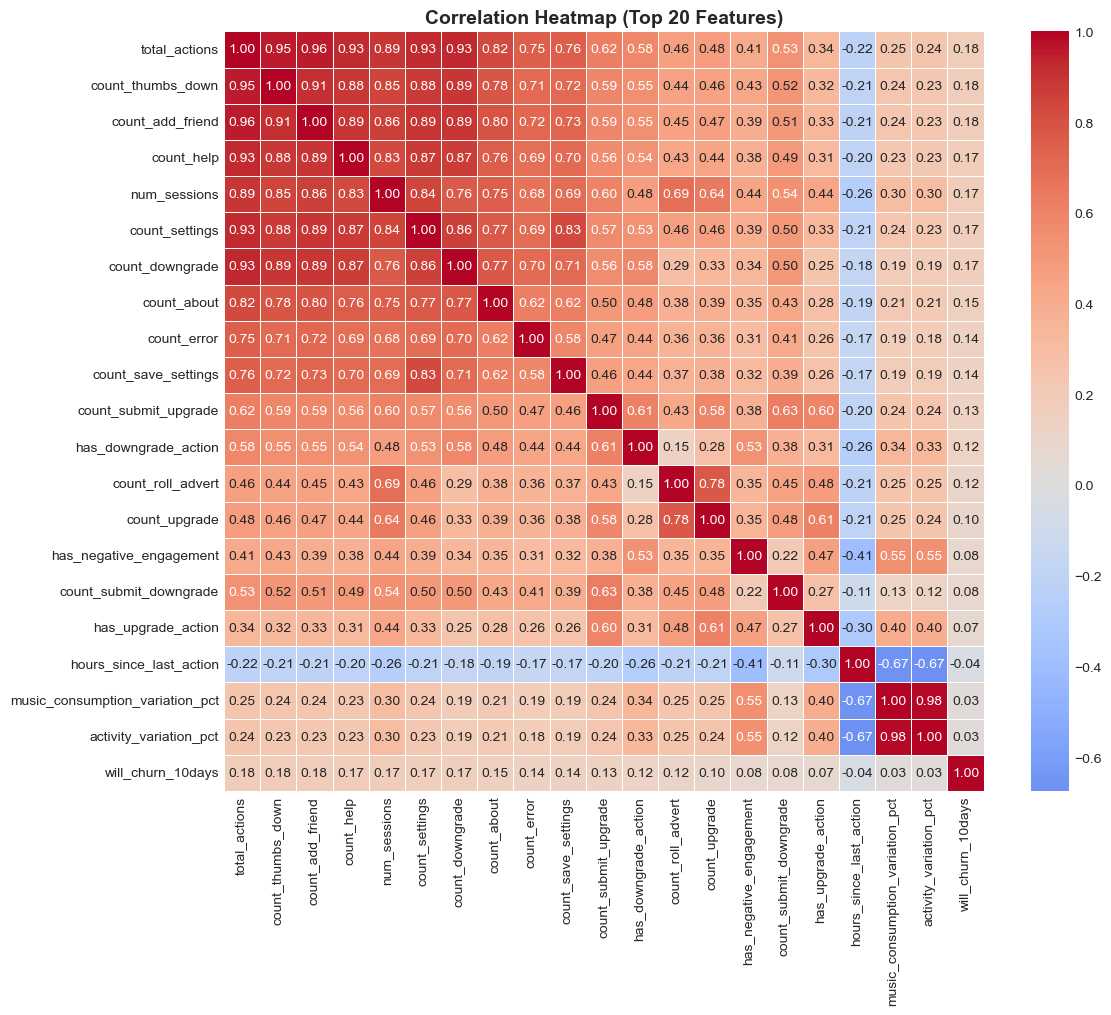

In [ ]:
plot_correlation_heatmap(df_consistant)

In [ ]:
def remove_correlated_features(df, threshold=0.9):
    """
    Remove highly correlated features.
    """
    # Correlation matrix
    feature_cols = [col for col in df.columns 
                   if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]
    
    corr_matrix = df[feature_cols].corr().abs()
    
    # Find pairs with correlation > threshold
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                # Keep the one more correlated with target
                corr_target_i = abs(df[corr_matrix.columns[i]].corr(df['will_churn_10days']))
                corr_target_j = abs(df[corr_matrix.columns[j]].corr(df['will_churn_10days']))
                
                if corr_target_i < corr_target_j:
                    to_drop.add(corr_matrix.columns[i])
                else:
                    to_drop.add(corr_matrix.columns[j])
    
    print(f"Removing {len(to_drop)} correlated features:")
    print(list(to_drop))
    
    df_cleaned = df.drop(columns=list(to_drop))
    return df_cleaned



In [ ]:
df_cleaned = remove_correlated_features(df_buffered, threshold=0.85)

Removing 7 correlated features:
['count_downgrade', 'count_help', 'count_add_friend', 'num_sessions', 'count_settings', 'count_thumbs_down', 'activity_variation_pct']


In [ ]:
df_cleaned

,userId,session_start,registration,will_churn_10days,hours_since_last_action,days_since_registration,count_about,count_error,count_save_settings,count_upgrade,...,count_submit_upgrade,count_roll_advert,total_actions,skip_rate,like_ratio,music_consumption_variation_pct,previous_week_actions,has_downgrade_action,has_upgrade_action,has_negative_engagement
sessionId,,,,,,,,,,,,,,,,,,,,,
698,1000804,2018-10-02 15:05:45,2018-09-01 08:10:27,0,750.921667,31.288403,0,0,0,0,...,0,0,0,0.000000,0.000000,0,0,0,0,0
15593,1000804,2018-10-22 14:12:24,2018-09-01 08:10:27,1,70.368889,51.251354,0,0,0,1,...,0,10,203,0.212500,0.062500,100,0,0,1,1
649,1001177,2018-10-02 11:59:06,2018-09-20 04:34:26,0,295.411111,12.308796,0,0,0,0,...,0,0,0,0.000000,0.000000,0,0,0,0,0
872,1001256,2018-10-12 15:47:47,2018-06-11 01:16:56,0,2966.514167,123.604757,0,0,0,0,...,0,0,0,0.000000,0.000000,0,0,0,0,0
485,1002584,2018-10-01 14:27:06,2018-06-11 20:43:43,1,2681.723056,111.738461,0,0,0,0,...,0,0,0,0.000000,0.000000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130445,1996686,2018-11-07 06:38:11,2018-09-10 21:57:51,0,260.804167,57.361343,0,0,0,0,...,0,1,19,0.214286,0.000000,100,0,0,0,0
166797,1996686,2018-11-07 18:32:54,2018-09-10 21:57:51,0,11.187778,57.857674,0,0,0,0,...,0,1,34,0.240000,0.080000,100,0,0,0,0
141766,1997612,2018-11-07 09:05:35,2018-08-31 03:10:10,0,177.697500,68.246817,0,0,0,0,...,0,0,62,0.115385,0.038462,100,0,1,0,1


### First training with Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

def random_forest_training(df_features):
    # Prepare data
    feature_cols = [col for col in df_features.columns 
                    if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]

    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']

    print(f"Features: {len(feature_cols)}")
    print(f"Dataset size: {len(X)}")
    print(f"Label distribution:\n{y.value_counts(normalize=True)}")

    # Split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train Random Forest with better parameters for imbalanced data
    model = RandomForestClassifier(
        n_estimators=100,           # Number of trees
        max_depth=15,               # Limit depth to avoid overfitting
        min_samples_split=10,       # Minimum samples to split a node
        min_samples_leaf=5,         # Minimum samples in a leaf
        class_weight='balanced',    # CRITICAL: Handle class imbalance
        random_state=42,
        n_jobs=-1                   # Use all CPU cores
    )

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of churn

    # Evaluation with appropriate metrics
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)

    print(f"\nAccuracy: {model.score(X_test, y_test):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Feature importance
    print("\nTop 10 Most Important Features:")
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(feature_importance.head(10).to_string(index=False))

In [ ]:
random_forest_training(df_consistant)

Features: 24
Dataset size: 119755
Label distribution:
will_churn_10days
0    0.892272
1    0.107728
Name: proportion, dtype: float64

MODEL EVALUATION

Accuracy: 0.8674
F1-Score: 0.4443
ROC-AUC: 0.7911

Confusion Matrix:
[[19504  1867]
 [ 1310  1270]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.91      0.92     21371
       Churn       0.40      0.49      0.44      2580

    accuracy                           0.87     23951
   macro avg       0.67      0.70      0.68     23951
weighted avg       0.88      0.87      0.87     23951


Top 10 Most Important Features:
                feature  importance
days_since_registration    0.105895
hours_since_last_action    0.099243
          total_actions    0.087923
             like_ratio    0.086968
              skip_rate    0.073177
      count_thumbs_down    0.066636
       count_add_friend    0.062170
      count_roll_advert    0.055790
           num_sessions    0.055761
    

We need to deal with classe imbalance

### Second try with XG Boost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import numpy as np

def XGB_training(df_features):

    # Prepare data
    feature_cols = [col for col in df_features.columns 
                    if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]

    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']

    # Split (NO resampling here!)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Calculate scale_pos_weight: ratio of negative to positive class
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    print(f"Class distribution in train:")
    print(y_train.value_counts())
    print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

    # XGBoost with optimal parameters for churn prediction
    model = xgb.XGBClassifier(
        # Handle imbalanced classes
        scale_pos_weight=scale_pos_weight,  # CRITICAL for imbalanced data
        
        # Model complexity
        n_estimators=200,                   # Number of boosting rounds
        max_depth=6,                        # Tree depth (prevent overfitting)
        learning_rate=0.05,                 # Lower = more robust but slower
        
        # Regularization
        min_child_weight=5,                 # Minimum sum of weights in a child
        gamma=0.1,                          # Minimum loss reduction for split
        subsample=0.8,                      # Fraction of samples per tree
        colsample_bytree=0.8,               # Fraction of features per tree
        reg_alpha=0.1,                      # L1 regularization
        reg_lambda=1.0,                     # L2 regularization
        
        # Optimization
        objective='binary:logistic',        # Binary classification
        eval_metric='auc',                  # MOVED HERE: Use AUC for evaluation
        early_stopping_rounds=20,           # MOVED HERE: Stop if no improvement
        random_state=42,
        n_jobs=-1
    )

    # Train (simplified - no need to pass eval_metric again)
    print("\nTraining XGBoost model...")
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10  # Print progress every 10 rounds
    )

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluation
    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)

    print(f"\nAccuracy: {model.score(X_test, y_test):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"\nTrue Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Feature importance
    import pandas as pd
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))

    # Best iteration (from early stopping)
    print(f"\nBest iteration: {model.best_iteration}")
    print(f"Best score (AUC on validation): {model.best_score:.4f}")

In [ ]:
XGB_training(df_cleaned)

Class distribution in train:
will_churn_10days
0    97504
1    10321
Name: count, dtype: int64

Calculated scale_pos_weight: 9.45

Training XGBoost model...
[0]	validation_0-auc:0.68284	validation_1-auc:0.68163
[10]	validation_0-auc:0.70909	validation_1-auc:0.69839
[20]	validation_0-auc:0.71705	validation_1-auc:0.70404
[30]	validation_0-auc:0.72307	validation_1-auc:0.70730
[40]	validation_0-auc:0.72911	validation_1-auc:0.71010
[50]	validation_0-auc:0.73506	validation_1-auc:0.71376
[60]	validation_0-auc:0.74028	validation_1-auc:0.71631
[70]	validation_0-auc:0.74527	validation_1-auc:0.71831
[80]	validation_0-auc:0.74920	validation_1-auc:0.71997
[90]	validation_0-auc:0.75353	validation_1-auc:0.72253
[100]	validation_0-auc:0.75659	validation_1-auc:0.72405
[110]	validation_0-auc:0.76080	validation_1-auc:0.72616
[120]	validation_0-auc:0.76546	validation_1-auc:0.72870
[130]	validation_0-auc:0.76991	validation_1-auc:0.73124
[140]	validation_0-auc:0.77548	validation_1-auc:0.73439
[150]	validati

### Rebalance the classes with a SMOTE function

In [ ]:
# We apply smote only to train sets
def apply_smote(df_features):
    """
    Apply SMOTE to balance classes.
    """
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    
    # Prepare data
    feature_cols = [col for col in df_features.columns 
                   if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"Before SMOTE: {len(y_train)} samples")
    print(f"After SMOTE:  {len(y_train_balanced)} samples")
    print(f"Class 0: {(y_train_balanced==0).sum()}, Class 1: {(y_train_balanced==1).sum()}")
    
    return X_train_balanced, y_train_balanced, X_test, y_test

In [ ]:
X_train_balanced, y_train_balanced, X_test, y_test = apply_smote(df_features)

Before SMOTE: 110155 samples
After SMOTE:  199668 samples
Class 0: 99834, Class 1: 99834


In [ ]:
def train_random_forest(X_train, y_train, X_test, y_test):
    """
    Train Random Forest and evaluate.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, roc_auc_score
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    return rf, roc_auc

In [ ]:
model, score = train_random_forest(X_train_balanced, y_train_balanced, X_test, y_test)

ROC-AUC: 0.7625

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.94      0.94     24959
       Churn       0.38      0.37      0.38      2580

    accuracy                           0.88     27539
   macro avg       0.66      0.66      0.66     27539
weighted avg       0.88      0.88      0.88     27539



Still performs very bad

## EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def create_churn_eda(df_features, save_figures=True, figsize_base=(15, 10)):
    """
    Creates comprehensive EDA visualizations for churn prediction.
    
    Parameters:
    -----------
    df_features : pd.DataFrame
        DataFrame with features and 'will_churn_10days' label
    save_figures : bool
        If True, saves figures as PNG files
    figsize_base : tuple
        Base figure size for plots
    """
    
    # Prepare data
    feature_cols = [col for col in df_features.columns 
                    if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]
    
    df = df_features.copy()
    
    # Create churn label for better readability
    df['churn_label'] = df['will_churn_10days'].map({0: 'No Churn', 1: 'Churn'})
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of features: {len(feature_cols)}")
    print(f"\nChurn distribution:")
    print(df['will_churn_10days'].value_counts())
    print(f"\nChurn rate: {df['will_churn_10days'].mean()*100:.2f}%")
    
    # ==================================================================
    # 1. LABEL DISTRIBUTION
    # ==================================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count plot
    churn_counts = df['churn_label'].value_counts()
    axes[0].bar(churn_counts.index, churn_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
    axes[0].set_title('Churn Distribution (Count)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Sessions', fontsize=12)
    axes[0].set_xlabel('Churn Status', fontsize=12)
    for i, v in enumerate(churn_counts.values):
        axes[0].text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    colors = ['#2ecc71', '#e74c3c']
    axes[1].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', 
                colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    axes[1].set_title('Churn Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    # ==================================================================
    # 2. TEMPORAL FEATURES ANALYSIS
    # ==================================================================
    temporal_features = ['hours_since_last_action', 'days_since_registration', 'days_active']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, feature in enumerate(temporal_features):
        # Box plot
        sns.boxplot(data=df, x='churn_label', y=feature, ax=axes[idx], palette=['#2ecc71', '#e74c3c'])
        axes[idx].set_title(f'{feature.replace("_", " ").title()}\nby Churn Status', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Churn Status', fontsize=11)
        axes[idx].set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
        
        # Add median values
        medians = df.groupby('churn_label')[feature].median()
        for i, label in enumerate(['No Churn', 'Churn']):
            axes[idx].text(i, medians[label], f'Med: {medians[label]:.1f}', 
                          ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    if save_figures:
        plt.savefig('/mnt/user-data/outputs/02_temporal_features.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ==================================================================
    # 3. ACTIVITY METRICS
    # ==================================================================
    activity_features = ['total_actions', 'num_sessions', 'avg_actions_per_day', 'unique_pages']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, feature in enumerate(activity_features):
        # Violin plot for better distribution visualization
        sns.violinplot(data=df, x='churn_label', y=feature, ax=axes[idx], 
                      palette=['#2ecc71', '#e74c3c'], inner='quartile')
        axes[idx].set_title(f'{feature.replace("_", " ").title()}\nDistribution by Churn', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Churn Status', fontsize=11)
        axes[idx].set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
        
        # Add mean values
        means = df.groupby('churn_label')[feature].mean()
        for i, label in enumerate(['No Churn', 'Churn']):
            axes[idx].axhline(means[label], linestyle='--', linewidth=1, alpha=0.7)
            axes[idx].text(i, means[label], f'μ={means[label]:.1f}', 
                          ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    if save_figures:
        plt.savefig('/mnt/user-data/outputs/03_activity_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ==================================================================
    # 4. ENGAGEMENT RATIOS
    # ==================================================================
    ratio_features = ['ratio_thumbs_up', 'ratio_thumbs_down', 'ratio_engagement', 
                      'ratio_next_song', 'ratio_errors']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(ratio_features):
        if idx < len(ratio_features):
            # Histogram with KDE
            for label, color in zip(['No Churn', 'Churn'], ['#2ecc71', '#e74c3c']):
                data = df[df['churn_label'] == label][feature]
                axes[idx].hist(data, bins=30, alpha=0.5, label=label, color=color, density=True)
                
                # Add KDE
                if len(data) > 1 and data.std() > 0:
                    kde_data = data.dropna()
                    if len(kde_data) > 1:
                        density = stats.gaussian_kde(kde_data)
                        xs = np.linspace(kde_data.min(), kde_data.max(), 200)
                        axes[idx].plot(xs, density(xs), color=color, linewidth=2)
            
            axes[idx].set_title(f'{feature.replace("_", " ").title()}', 
                               fontsize=11, fontweight='bold')
            axes[idx].set_xlabel(feature.replace('_', ' ').title(), fontsize=10)
            axes[idx].set_ylabel('Density', fontsize=10)
            axes[idx].legend()
    
    # Remove empty subplot
    if len(ratio_features) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    if save_figures:
        plt.savefig('/mnt/user-data/outputs/04_engagement_ratios.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ==================================================================
    # 5. CRITICAL CHURN INDICATORS
    # ==================================================================
    critical_features = ['ratio_downgrade_actions', 'ratio_help_actions', 
                         'has_downgrade_action', 'has_upgrade_action']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(critical_features):
        if 'has_' in feature:
            # For binary features: stacked bar chart
            crosstab = pd.crosstab(df[feature], df['churn_label'], normalize='columns') * 100
            crosstab.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'], 
                         alpha=0.7, edgecolor='black')
            axes[idx].set_title(f'{feature.replace("_", " ").title()}\n(% within Churn Group)', 
                               fontsize=11, fontweight='bold')
            axes[idx].set_xlabel(feature.replace('_', ' ').title(), fontsize=10)
            axes[idx].set_ylabel('Percentage', fontsize=10)
            axes[idx].legend(title='Churn Status')
            axes[idx].set_xticklabels(['No', 'Yes'], rotation=0)
        else:
            # For ratio features: box plot
            sns.boxplot(data=df, x='churn_label', y=feature, ax=axes[idx], 
                       palette=['#2ecc71', '#e74c3c'])
            axes[idx].set_title(f'{feature.replace("_", " ").title()}\nby Churn Status', 
                               fontsize=11, fontweight='bold')
            axes[idx].set_xlabel('Churn Status', fontsize=10)
            axes[idx].set_ylabel(feature.replace('_', ' ').title(), fontsize=10)
    
    plt.tight_layout()
    if save_figures:
        plt.savefig('/mnt/user-data/outputs/05_critical_churn_indicators.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ==================================================================
    # 6. PAGE ACTION COUNTS
    # ==================================================================
    page_count_features = [col for col in feature_cols if col.startswith('count_') and col != 'count_roll_advert']
    page_count_features = page_count_features[:12]  # Limit to top 12
    
    # Calculate mean counts by churn status
    means_data = []
    for feature in page_count_features:
        no_churn_mean = df[df['will_churn_10days'] == 0][feature].mean()
        churn_mean = df[df['will_churn_10days'] == 1][feature].mean()
        means_data.append({
            'feature': feature.replace('count_', '').replace('_', ' ').title(),
            'No Churn': no_churn_mean,
            'Churn': churn_mean
        })
    
    means_df = pd.DataFrame(means_data).set_index('feature')
    
    fig, ax = plt.subplots(figsize=(14, 8))
    means_df.plot(kind='barh', ax=ax, color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
    ax.set_title('Average Page Action Counts by Churn Status', fontsize=14, fontweight='bold')
    ax.set_xlabel('Average Count', fontsize=12)
    ax.set_ylabel('Page Action', fontsize=12)
    ax.legend(title='Churn Status', fontsize=11)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    if save_figures:
        plt.savefig('/mnt/user-data/outputs/06_page_action_counts.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ==================================================================
    # 7. CORRELATION HEATMAP (Top Features)
    # ==================================================================
    # Select top features based on correlation with target
    correlations = df[feature_cols].corrwith(df['will_churn_10days']).abs().sort_values(ascending=False)
    top_features = correlations.head(15).index.tolist()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    correlation_matrix = df[top_features + ['will_churn_10days']].corr()
    
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r', 
                center=0, ax=ax, cbar_kws={'label': 'Correlation'})
    ax.set_title('Correlation Heatmap - Top 15 Features', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    if save_figures:
        plt.savefig('/mnt/user-data/outputs/07_correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ==================================================================
    # 8. FEATURE IMPORTANCE (based on correlation)
    # ==================================================================
    fig, ax = plt.subplots(figsize=(10, 8))
    
    top_20_corr = correlations.head(20)
    colors = ['#e74c3c' if x > 0 else '#3498db' for x in df[top_20_corr.index].corrwith(df['will_churn_10days'])]
    
    ax.barh(range(len(top_20_corr)), top_20_corr.values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(top_20_corr)))
    ax.set_yticklabels([f.replace('_', ' ').title() for f in top_20_corr.index], fontsize=10)
    ax.set_xlabel('Absolute Correlation with Churn', fontsize=12)
    ax.set_title('Top 20 Features by Correlation with Churn', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#e74c3c', alpha=0.7, label='Positive Correlation'),
                      Patch(facecolor='#3498db', alpha=0.7, label='Negative Correlation')]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    if save_figures:
        plt.savefig('/mnt/user-data/outputs/08_feature_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ==================================================================
    # 9. STATISTICAL SUMMARY
    # ==================================================================
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY - KEY DIFFERENCES")
    print("="*70)
    
    key_features = ['hours_since_last_action', 'days_since_registration', 'total_actions', 
                   'ratio_downgrade_actions', 'ratio_engagement', 'ratio_next_song']
    
    summary_data = []
    for feature in key_features:
        no_churn_data = df[df['will_churn_10days'] == 0][feature]
        churn_data = df[df['will_churn_10days'] == 1][feature]
        
        # T-test
        t_stat, p_value = stats.ttest_ind(no_churn_data.dropna(), churn_data.dropna())
        
        summary_data.append({
            'Feature': feature.replace('_', ' ').title(),
            'No Churn (Mean)': f"{no_churn_data.mean():.2f}",
            'Churn (Mean)': f"{churn_data.mean():.2f}",
            'Difference': f"{((churn_data.mean() - no_churn_data.mean()) / no_churn_data.mean() * 100):.1f}%",
            'P-value': f"{p_value:.4f}",
            'Significant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'No'
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    print("\n*** p < 0.001 (highly significant)")
    print("**  p < 0.01 (very significant)")
    print("*   p < 0.05 (significant)")
    
    print("\n" + "="*70)
    print("EDA COMPLETE - All figures saved!")
    print("="*70)
    
    return correlations


# Example usage:
# correlations = create_churn_eda(df_features, save_figures=True)

Dataset shape: (137694, 43)
Number of features: 38

Churn distribution:
will_churn_10days
0    124793
1     12901
Name: count, dtype: int64

Churn rate: 9.37%


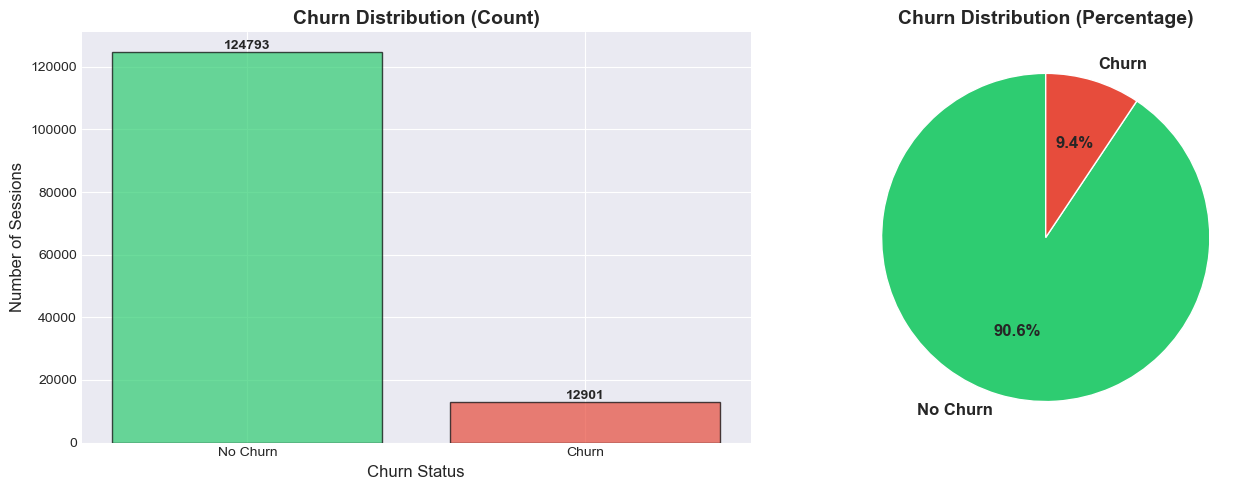

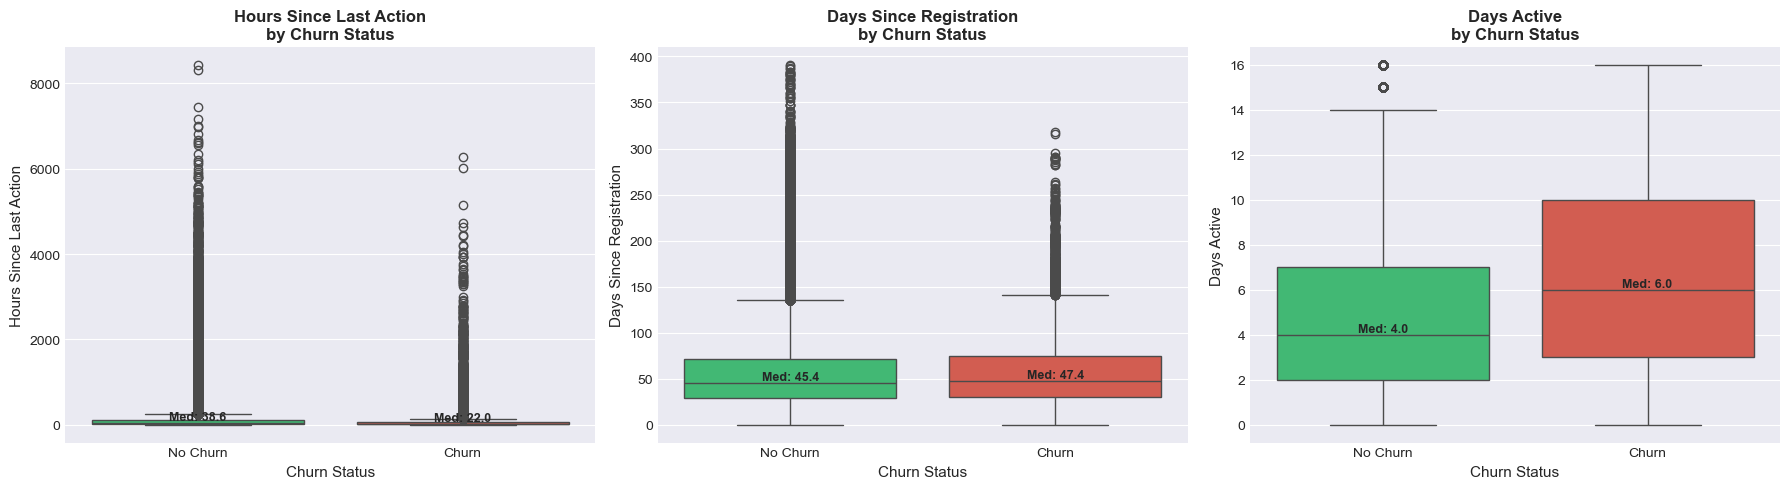

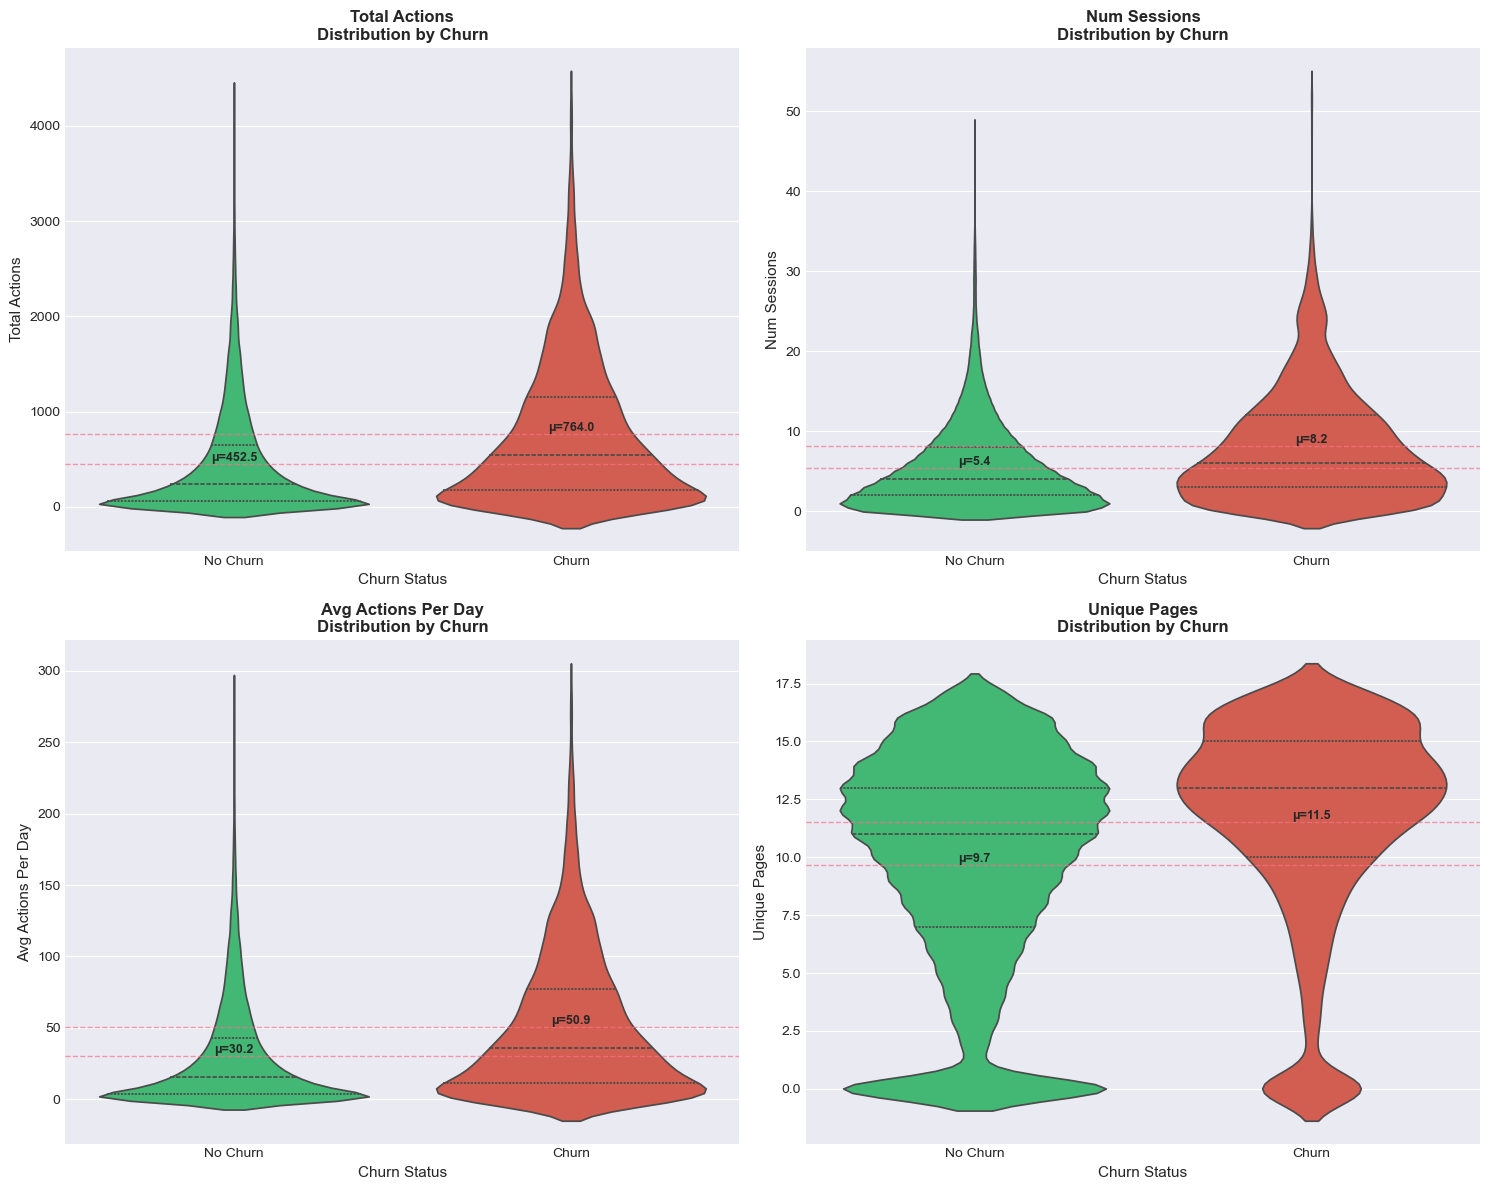

KeyError: 'ratio_thumbs_up'

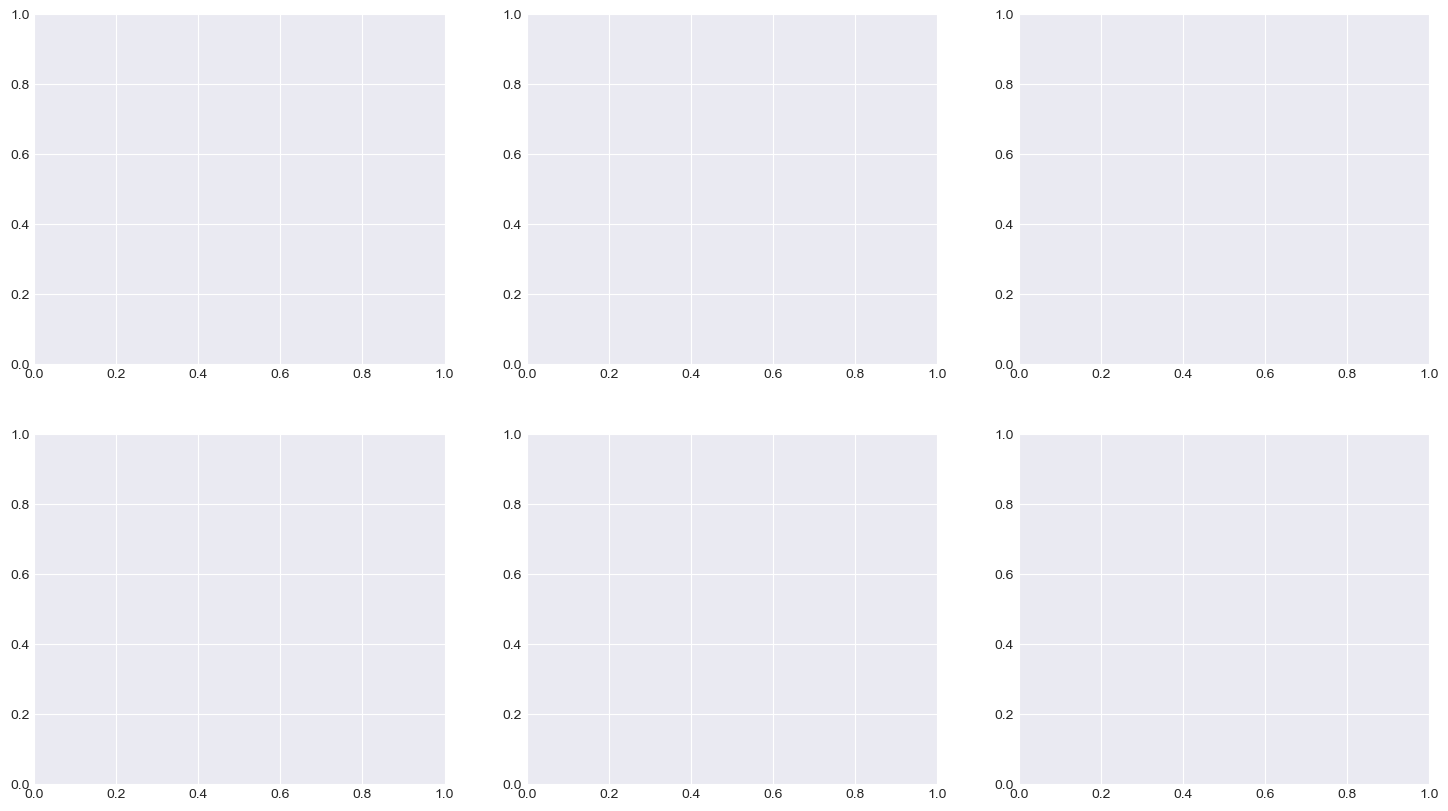

In [ ]:
create_churn_eda(df_features, save_figures=False)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 38.32it/s]


KeyboardInterrupt: 

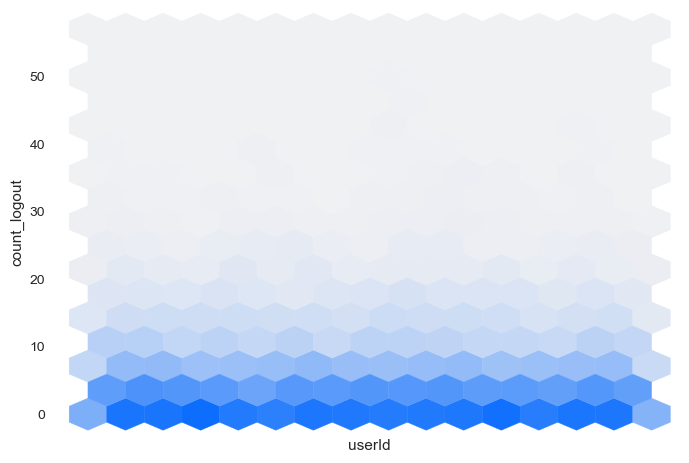

In [ ]:
import ydata_profiling
X.profile_report()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


def eda_churn_features(df_features):
    """
    Comprehensive EDA for churn prediction feature dataset.
    
    Parameters:
    -----------
    df_features : pd.DataFrame
        Output from create_churn_features() function
    """
    
    print("=" * 80)
    print("EXPLORATORY DATA ANALYSIS - CHURN PREDICTION DATASET")
    print("=" * 80)
    
    # ============================================================================
    # 1. BASIC DATASET INFO
    # ============================================================================
    print("\n1. DATASET OVERVIEW")
    print("-" * 80)
    print(f"Total sessions: {len(df_features):,}")
    print(f"Total users: {df_features['userId'].nunique():,}")
    print(f"Features: {len(df_features.columns) - 4}")  # Excluding userId, session_start, registration, label
    print(f"Date range: {df_features['session_start'].min()} to {df_features['session_start'].max()}")
    print(f"\nMemory usage: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # ============================================================================
    # 2. TARGET VARIABLE ANALYSIS
    # ============================================================================
    print("\n\n2. TARGET VARIABLE (will_churn_10days)")
    print("-" * 80)
    churn_counts = df_features['will_churn_10days'].value_counts()
    churn_pct = df_features['will_churn_10days'].value_counts(normalize=True) * 100
    
    print(f"No Churn (0): {churn_counts.get(0, 0):,} sessions ({churn_pct.get(0, 0):.2f}%)")
    print(f"Churn (1):    {churn_counts.get(1, 0):,} sessions ({churn_pct.get(1, 0):.2f}%)")
    
    imbalance_ratio = churn_counts.max() / churn_counts.min()
    print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 3:
        print("⚠️  WARNING: Significant class imbalance detected!")
        print("   Consider using: SMOTE, class weights, or stratified sampling")
    
    # ============================================================================
    # 3. MISSING VALUES
    # ============================================================================
    print("\n\n3. MISSING VALUES")
    print("-" * 80)
    missing = df_features.isnull().sum()
    missing_pct = (missing / len(df_features)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing[missing > 0],
        'Percentage': missing_pct[missing > 0]
    }).sort_values('Missing Count', ascending=False)
    
    if len(missing_df) > 0:
        print(missing_df)
        print(f"\nColumns with missing values: {len(missing_df)}")
    else:
        print("✓ No missing values found!")
    
    # ============================================================================
    # 4. FEATURE STATISTICS BY CHURN STATUS
    # ============================================================================
    print("\n\n4. KEY FEATURES BY CHURN STATUS")
    print("-" * 80)
    
    # Select numeric features only
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    # Top features by difference between churners and non-churners
    churners = df_features[df_features['will_churn_10days'] == 1]
    non_churners = df_features[df_features['will_churn_10days'] == 0]
    
    feature_comparison = []
    for col in feature_cols[:20]:  # Top 20 features
        if col in churners.columns and col in non_churners.columns:
            mean_churn = churners[col].mean()
            mean_no_churn = non_churners[col].mean()
            diff_pct = ((mean_churn - mean_no_churn) / (mean_no_churn + 1e-10)) * 100
            
            feature_comparison.append({
                'Feature': col,
                'Churners (mean)': mean_churn,
                'Non-Churners (mean)': mean_no_churn,
                'Diff %': diff_pct
            })
    
    comparison_df = pd.DataFrame(feature_comparison).sort_values('Diff %', key=abs, ascending=False)
    print("\nTop 10 features with largest differences:")
    print(comparison_df.head(10).to_string(index=False))
    
    # ============================================================================
    # 5. CORRELATION WITH TARGET
    # ============================================================================
    print("\n\n5. CORRELATION WITH TARGET VARIABLE")
    print("-" * 80)
    
    correlations = df_features[feature_cols].corrwith(df_features['will_churn_10days']).abs()
    top_correlations = correlations.sort_values(ascending=False).head(15)
    
    print("Top 15 most correlated features:")
    for feat, corr in top_correlations.items():
        print(f"  {feat:40s}: {corr:.4f}")
    
    # ============================================================================
    # 6. FEATURE DISTRIBUTIONS
    # ============================================================================
    print("\n\n6. FEATURE DISTRIBUTION ANALYSIS")
    print("-" * 80)
    
    # Check for zero-variance features
    zero_var_features = [col for col in feature_cols 
                         if df_features[col].nunique() <= 1]
    if zero_var_features:
        print(f"⚠️  Zero-variance features (consider removing): {zero_var_features}")
    else:
        print("✓ No zero-variance features")
    
    # Check for highly skewed features
    skewed_features = []
    for col in feature_cols:
        if df_features[col].std() > 0:
            skewness = df_features[col].skew()
            if abs(skewness) > 2:
                skewed_features.append((col, skewness))
    
    if skewed_features:
        print(f"\n⚠️  Highly skewed features (|skew| > 2): {len(skewed_features)}")
        for feat, skew_val in sorted(skewed_features, key=lambda x: abs(x[1]), reverse=True)[:5]:
            print(f"  {feat:40s}: {skew_val:.2f}")
        print("   Consider log transformation or StandardScaler")
    
    # ============================================================================
    # 7. TEMPORAL PATTERNS
    # ============================================================================
    print("\n\n7. TEMPORAL PATTERNS")
    print("-" * 80)
    
    # Account age analysis
    print(f"Days since registration:")
    print(f"  Mean: {df_features['days_since_registration'].mean():.1f} days")
    print(f"  Median: {df_features['days_since_registration'].median():.1f} days")
    print(f"  Min: {df_features['days_since_registration'].min():.1f} days")
    print(f"  Max: {df_features['days_since_registration'].max():.1f} days")
    
    # Inactivity analysis
    if 'hours_since_last_action' in df_features.columns:
        valid_hours = df_features['hours_since_last_action'].dropna()
        if len(valid_hours) > 0:
            print(f"\nHours since last action:")
            print(f"  Mean: {valid_hours.mean():.1f} hours")
            print(f"  Median: {valid_hours.median():.1f} hours")
            print(f"  75th percentile: {valid_hours.quantile(0.75):.1f} hours")
    
    # ============================================================================
    # 8. ENGAGEMENT METRICS
    # ============================================================================
    print("\n\n8. ENGAGEMENT METRICS")
    print("-" * 80)
    
    engagement_metrics = ['total_actions', 'days_active', 'num_sessions', 
                         'avg_actions_per_day', 'unique_pages']
    
    for metric in engagement_metrics:
        if metric in df_features.columns:
            print(f"\n{metric}:")
            print(f"  Overall mean: {df_features[metric].mean():.2f}")
            print(f"  Churners: {churners[metric].mean():.2f}")
            print(f"  Non-churners: {non_churners[metric].mean():.2f}")
    
    # ============================================================================
    # 9. RECOMMENDATIONS
    # ============================================================================
    print("\n\n9. MODELING RECOMMENDATIONS")
    print("-" * 80)
    
    recommendations = []
    
    # Class imbalance
    if imbalance_ratio > 3:
        recommendations.append("• Use class_weight='balanced' or SMOTE for imbalanced data")
    
    # Skewed features
    if len(skewed_features) > 5:
        recommendations.append("• Apply StandardScaler or RobustScaler for skewed features")
    
    # Missing values
    if len(missing_df) > 0:
        recommendations.append("• Handle missing values (imputation or removal)")
    
    # Correlation
    if top_correlations.max() < 0.2:
        recommendations.append("• Low correlation with target - consider feature engineering")
    
    # Zero variance
    if zero_var_features:
        recommendations.append(f"• Remove {len(zero_var_features)} zero-variance features")
    
    recommendations.append("• Use cross-validation with stratification")
    recommendations.append("• Consider ensemble methods (XGBoost, Random Forest)")
    recommendations.append("• Monitor for overfitting given feature count")
    
    if recommendations:
        for rec in recommendations:
            print(rec)
    
    print("\n" + "=" * 80)
    
    return {
        'n_sessions': len(df_features),
        'n_users': df_features['userId'].nunique(),
        'churn_rate': churn_pct.get(1, 0),
        'imbalance_ratio': imbalance_ratio,
        'top_features': top_correlations.head(10).to_dict(),
        'missing_features': missing_df.index.tolist() if len(missing_df) > 0 else [],
        'zero_var_features': zero_var_features
    }


def plot_churn_analysis(df_features):
    """
    Create visualizations for churn analysis.
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Churn Prediction - Feature Analysis', fontsize=16, fontweight='bold')
    
    # 1. Target distribution
    ax = axes[0, 0]
    df_features['will_churn_10days'].value_counts().plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'])
    ax.set_title('Target Distribution')
    ax.set_xlabel('Churn Status')
    ax.set_ylabel('Count')
    ax.set_xticklabels(['No Churn', 'Churn'], rotation=0)
    
    # 2. Total actions by churn status
    ax = axes[0, 1]
    df_features.boxplot(column='total_actions', by='will_churn_10days', ax=ax)
    ax.set_title('Total Actions by Churn Status')
    ax.set_xlabel('Churn Status')
    ax.set_ylabel('Total Actions')
    plt.sca(ax)
    plt.xticks([1, 2], ['No Churn', 'Churn'])
    
    # 3. Days since registration
    ax = axes[0, 2]
    df_features.boxplot(column='days_since_registration', by='will_churn_10days', ax=ax)
    ax.set_title('Account Age by Churn Status')
    ax.set_xlabel('Churn Status')
    ax.set_ylabel('Days Since Registration')
    plt.sca(ax)
    plt.xticks([1, 2], ['No Churn', 'Churn'])
    
    # 4. Engagement ratio by churn
    ax = axes[1, 0]
    if 'ratio_engagement' in df_features.columns:
        df_features.boxplot(column='ratio_engagement', by='will_churn_10days', ax=ax)
        ax.set_title('Engagement Ratio by Churn Status')
        ax.set_xlabel('Churn Status')
        ax.set_ylabel('Engagement Ratio')
        plt.sca(ax)
        plt.xticks([1, 2], ['No Churn', 'Churn'])
    
    # 5. Error ratio by churn
    ax = axes[1, 1]
    if 'ratio_errors' in df_features.columns:
        df_features.boxplot(column='ratio_errors', by='will_churn_10days', ax=ax)
        ax.set_title('Error Ratio by Churn Status')
        ax.set_xlabel('Churn Status')
        ax.set_ylabel('Error Ratio')
        plt.sca(ax)
        plt.xticks([1, 2], ['No Churn', 'Churn'])
    
    # 6. Correlation heatmap (top features)
    ax = axes[1, 2]
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols if col not in ['userId']]
    
    # Select top correlated features with target
    correlations = df_features[feature_cols].corrwith(df_features['will_churn_10days']).abs()
    top_features = correlations.nlargest(8).index.tolist()
    
    if 'will_churn_10days' not in top_features:
        top_features.append('will_churn_10days')
    
    corr_matrix = df_features[top_features].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax, 
                cbar_kws={'shrink': 0.8})
    ax.set_title('Feature Correlation (Top 8)')
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Feature importance proxy (correlation bars)
    fig, ax = plt.subplots(figsize=(12, 6))
    correlations.nlargest(15).sort_values().plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Top 15 Features by Correlation with Churn', fontsize=14, fontweight='bold')
    ax.set_xlabel('Absolute Correlation')
    ax.set_ylabel('Feature')
    plt.tight_layout()
    plt.show()


# Usage example
if __name__ == "__main__":
    # Assuming df_model_ready is your output from create_churn_features()
    # results = eda_churn_features(df_model_ready)
    # plot_churn_analysis(df_model_ready)
    pass

In [ ]:
eda_churn_features(df_features)

EXPLORATORY DATA ANALYSIS - CHURN PREDICTION DATASET

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Total sessions: 137,694
Total users: 16,607
Features: 33
Date range: 2018-10-01 00:00:01 to 2018-11-19 21:01:46

Memory usage: 46.22 MB


2. TARGET VARIABLE (will_churn_10days)
--------------------------------------------------------------------------------
No Churn (0): 124,793 sessions (90.63%)
Churn (1):    12,901 sessions (9.37%)

Class imbalance ratio: 9.67:1
⚠️  WARNING: Significant class imbalance detected!
   Consider using: SMOTE, class weights, or stratified sampling


3. MISSING VALUES
--------------------------------------------------------------------------------
✓ No missing values found!


4. KEY FEATURES BY CHURN STATUS
--------------------------------------------------------------------------------

Top 10 features with largest differences:
            Feature  Churners (mean)  Non-Churners (mean)    Diff %
    count

{'n_sessions': 137694,
 'n_users': 16607,
 'churn_rate': np.float64(9.36932618705245),
 'imbalance_ratio': 9.673126114254709,
 'top_features': {'count_home': 0.15652713594226858,
  'total_actions': 0.15477384932640656,
  'avg_actions_per_day': 0.15477384932640645,
  'count_next_song': 0.1540972561604584,
  'count_add_playlist': 0.15326308700816899,
  'count_logout': 0.15136280027448476,
  'count_thumbs_down': 0.15005145563496425,
  'num_sessions': 0.14516862675570527,
  'count_add_friend': 0.14302583380048975,
  'count_settings': 0.13994224792726867},
 'missing_features': [],
 'zero_var_features': []}

### Remove non important features

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def find_and_remove_low_importance_features(df_features, threshold=0.01, method='random_forest'):
    """
    Find, display, and remove low importance features.
    
    Parameters:
    -----------
    df_features : pd.DataFrame
        Feature dataset with 'will_churn_10days' as target
    threshold : float
        Features with importance < threshold will be removed (default: 0.01 = 1%)
    method : str
        'random_forest' or 'correlation'
    
    Returns:
    --------
    df_cleaned : pd.DataFrame
        Dataset with low importance features removed
    removed_features : list
        List of removed feature names
    """
    
    print("=" * 70)
    print(f"REMOVING LOW IMPORTANCE FEATURES (threshold={threshold})")
    print("=" * 70)
    
    # Prepare data
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    print(f"\nOriginal features: {len(feature_cols)}")
    
    # Calculate feature importance
    if method == 'random_forest':
        print(f"Method: Random Forest")
        
        # Train quick Random Forest
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X, y)
        
        # Get importance
        importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
    elif method == 'correlation':
        print(f"Method: Correlation with target")
        
        # Calculate correlation
        importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': X.corrwith(y).abs().values
        }).sort_values('importance', ascending=False)
    
    # Find low importance features
    low_importance = importance[importance['importance'] < threshold]
    high_importance = importance[importance['importance'] >= threshold]
    
    print(f"\n--- LOW IMPORTANCE FEATURES (< {threshold}) ---")
    print(f"Found {len(low_importance)} features to remove:\n")
    print(low_importance.to_string(index=False))
    
    print(f"\n--- TOP 10 HIGH IMPORTANCE FEATURES ---")
    print(high_importance.head(10).to_string(index=False))
    
    # Remove low importance features
    features_to_keep = high_importance['feature'].tolist()
    removed_features = low_importance['feature'].tolist()
    
    # Keep metadata columns + high importance features + target
    columns_to_keep = ['userId', 'session_start', 'registration'] + features_to_keep + ['will_churn_10days']
    columns_to_keep = [col for col in columns_to_keep if col in df_features.columns]
    
    df_cleaned = df_features[columns_to_keep].copy()
    
    print(f"\n{'='*70}")
    print(f"✓ Removed {len(removed_features)} features")
    print(f"✓ Kept {len(features_to_keep)} features")
    print(f"{'='*70}")
    
    return df_cleaned, removed_features, importance


def plot_feature_importance(importance_df, top_n=20):
    """
    Plot feature importance.
    
    Parameters:
    -----------
    importance_df : pd.DataFrame
        DataFrame with 'feature' and 'importance' columns
    top_n : int
        Number of top features to display
    """
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    top_features = importance_df.head(top_n)
    
    ax.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Importance Score')
    ax.set_title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def quick_comparison(df_original, df_cleaned, sample_size=10000):
    """
    Quick comparison of model performance before/after feature removal.
    
    Parameters:
    -----------
    df_original : pd.DataFrame
        Original dataset with all features
    df_cleaned : pd.DataFrame
        Dataset with low importance features removed
    sample_size : int
        Number of samples to use (for speed)
    """
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score
    
    print("\n" + "=" * 70)
    print("QUICK PERFORMANCE COMPARISON")
    print("=" * 70)
    
    # Sample data if too large
    if len(df_original) > sample_size:
        df_original = df_original.sample(n=sample_size, random_state=42)
        df_cleaned = df_cleaned.loc[df_original.index]
    
    results = {}
    
    for name, df in [('Original', df_original), ('Cleaned', df_cleaned)]:
        # Prepare data
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols 
                       if col not in ['userId', 'will_churn_10days']]
        
        X = df[feature_cols].fillna(0)
        y = df['will_churn_10days']
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        
        # Evaluate
        y_proba = rf.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        
        results[name] = {
            'n_features': len(feature_cols),
            'roc_auc': roc_auc
        }
        
        print(f"\n{name} Dataset:")
        print(f"  Features: {len(feature_cols)}")
        print(f"  ROC-AUC: {roc_auc:.4f}")
    
    # Summary
    print(f"\n{'='*70}")
    diff_features = results['Original']['n_features'] - results['Cleaned']['n_features']
    diff_auc = results['Cleaned']['roc_auc'] - results['Original']['roc_auc']
    
    print(f"Features removed: {diff_features}")
    print(f"ROC-AUC difference: {diff_auc:+.4f}")
    
    if abs(diff_auc) < 0.01:
        print("✓ Minimal performance loss - feature removal is safe!")
    elif diff_auc > 0:
        print("✓ Performance improved - removed noise!")
    else:
        print("⚠️  Performance decreased - consider higher threshold")
    
    print("=" * 70)


# Simple usage example
if __name__ == "__main__":
    """
    # Usage:
    
    # 1. Remove low importance features
    df_cleaned, removed, importance = find_and_remove_low_importance_features(
        df_model_ready, 
        threshold=0.01,  # Remove features with < 1% importance
        method='random_forest'  # or 'correlation'
    )
    
    # 2. Plot importance
    plot_feature_importance(importance, top_n=20)
    
    # 3. Compare performance
    quick_comparison(df_model_ready, df_cleaned)
    """
    pass

In [ ]:
df_cleaned, removed, importance = find_and_remove_low_importance_features(X)

REMOVING LOW IMPORTANCE FEATURES (threshold=0.01)

Original features: 33
Method: Random Forest

--- LOW IMPORTANCE FEATURES (< 0.01) ---
Found 4 features to remove:

               feature  importance
count_submit_downgrade    0.008012
  count_submit_upgrade    0.007143
  has_downgrade_action    0.004130
    has_upgrade_action    0.002334

--- TOP 10 HIGH IMPORTANCE FEATURES ---
                feature  importance
        count_next_song    0.060985
          total_actions    0.055363
days_since_registration    0.055162
             count_home    0.048138
      count_thumbs_down    0.046579
    avg_actions_per_day    0.044352
      ratio_thumbs_down    0.043389
           num_sessions    0.041802
     count_add_playlist    0.041787
      count_roll_advert    0.040530

✓ Removed 4 features
✓ Kept 29 features


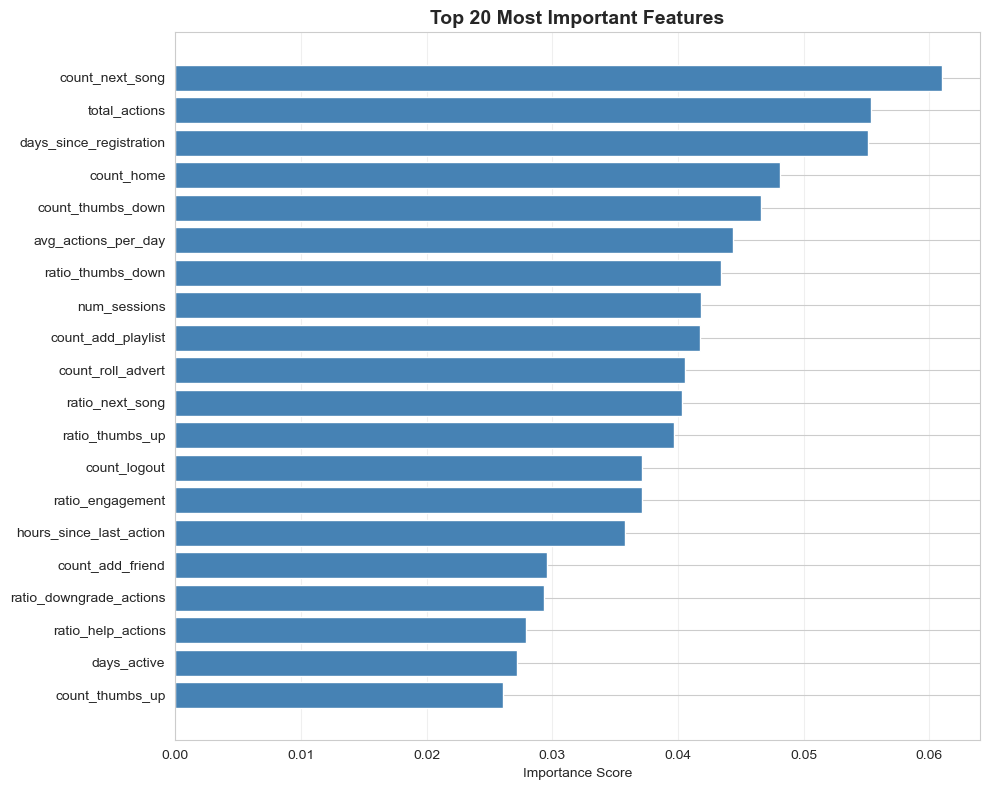

In [ ]:
plot_feature_importance(importance)

## Check if linear regression is suitable

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import warnings
warnings.filterwarnings('ignore')


def check_logistic_regression_suitability(df_features):
    """
    Comprehensive check to determine if Logistic Regression is suitable
    for your churn prediction problem.
    
    Parameters:
    -----------
    df_features : pd.DataFrame
        Feature dataset with 'will_churn_10days' as target
    """
    
    print("=" * 80)
    print("LOGISTIC REGRESSION SUITABILITY ANALYSIS")
    print("=" * 80)
    
    # Prepare data
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    print(f"\nDataset: {len(X):,} samples, {len(feature_cols)} features")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    
    # ========================================================================
    # 1. CHECK: Linear Separability (visual for top features)
    # ========================================================================
    print("\n" + "=" * 80)
    print("1. LINEAR SEPARABILITY CHECK")
    print("=" * 80)
    
    # Check correlation with target
    correlations = X.corrwith(y).abs().sort_values(ascending=False)
    top_features = correlations.head(5).index.tolist()
    
    print(f"\nTop 5 most correlated features with target:")
    for feat in top_features:
        corr = correlations[feat]
        print(f"  {feat:40s}: {corr:.4f}")
    
    if correlations.head(1).values[0] < 0.1:
        print("\n⚠️  WARNING: Very low correlation with target")
        print("   → Linear models might struggle")
        print("   → Consider tree-based models (XGBoost, Random Forest)")
    else:
        print("\n✓ Reasonable correlation detected")
        print("  → Linear relationships exist")
    
    # ========================================================================
    # 2. CHECK: Multicollinearity (VIF would be ideal, but computationally expensive)
    # ========================================================================
    print("\n" + "=" * 80)
    print("2. MULTICOLLINEARITY CHECK")
    print("=" * 80)
    
    # Check pairwise correlation among features
    corr_matrix = X[feature_cols[:20]].corr().abs()  # Top 20 features
    
    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > 0.8:
                high_corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    
    if high_corr_pairs:
        print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated feature pairs (>0.8):")
        for feat1, feat2, corr_val in high_corr_pairs[:5]:
            print(f"  {feat1[:30]:30s} <-> {feat2[:30]:30s}: {corr_val:.3f}")
        print("\n  → Consider removing redundant features")
        print("  → Or use regularization (L1/L2)")
    else:
        print("\n✓ No severe multicollinearity detected")
        print("  → Features are relatively independent")
    
    # ========================================================================
    # 3. CHECK: Class Balance
    # ========================================================================
    print("\n" + "=" * 80)
    print("3. CLASS BALANCE CHECK")
    print("=" * 80)
    
    class_counts = y.value_counts()
    imbalance_ratio = class_counts.max() / class_counts.min()
    minority_pct = (class_counts.min() / len(y)) * 100
    
    print(f"\nClass 0: {class_counts.get(0, 0):,} ({100 - minority_pct:.1f}%)")
    print(f"Class 1: {class_counts.get(1, 0):,} ({minority_pct:.1f}%)")
    print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 10:
        print("\n⚠️  SEVERE CLASS IMBALANCE")
        print("  → Use class_weight='balanced' in LogisticRegression")
        print("  → Or SMOTE for oversampling minority class")
        print("  → Evaluate with ROC-AUC, not accuracy")
    elif imbalance_ratio > 3:
        print("\n⚠️  MODERATE CLASS IMBALANCE")
        print("  → Use class_weight='balanced'")
        print("  → Monitor precision/recall, not just accuracy")
    else:
        print("\n✓ Relatively balanced classes")
    
    # ========================================================================
    # 4. BASELINE MODEL: Train a simple Logistic Regression
    # ========================================================================
    print("\n" + "=" * 80)
    print("4. BASELINE LOGISTIC REGRESSION PERFORMANCE")
    print("=" * 80)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train model with balanced class weights
    lr = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        solver='lbfgs'
    )
    lr.fit(X_train, y_train)
    
    # Predictions
    y_pred = lr.predict(X_test)
    y_proba = lr.predict_proba(X_test)[:, 1]
    
    # Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"\nTest Set Performance:")
    print(f"  ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    # Interpret ROC-AUC
    print("\nROC-AUC Interpretation:")
    if roc_auc >= 0.85:
        print(f"  ✓ EXCELLENT ({roc_auc:.4f}) - Logistic Regression works very well!")
    elif roc_auc >= 0.75:
        print(f"  ✓ GOOD ({roc_auc:.4f}) - Logistic Regression is suitable")
    elif roc_auc >= 0.65:
        print(f"  ⚠️  MODERATE ({roc_auc:.4f}) - Consider ensemble methods too")
    else:
        print(f"  ❌ POOR ({roc_auc:.4f}) - Tree-based models likely better")
    
    # ========================================================================
    # 5. CROSS-VALIDATION
    # ========================================================================
    print("\n" + "=" * 80)
    print("5. CROSS-VALIDATION (5-FOLD)")
    print("=" * 80)
    
    cv_scores = cross_val_score(lr, X_scaled, y, cv=5, scoring='roc_auc')
    
    print(f"\nCV ROC-AUC Scores: {cv_scores}")
    print(f"Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    if cv_scores.std() > 0.05:
        print("\n⚠️  High variance in CV scores")
        print("  → Model might be unstable")
        print("  → Consider more data or regularization")
    else:
        print("\n✓ Stable performance across folds")
    
    # ========================================================================
    # 6. FEATURE IMPORTANCE
    # ========================================================================
    print("\n" + "=" * 80)
    print("6. TOP 10 MOST IMPORTANT FEATURES (by coefficient)")
    print("=" * 80)
    
    # Get feature importance (absolute coefficients)
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': np.abs(lr.coef_[0])
    }).sort_values('coefficient', ascending=False)
    
    print("\n" + feature_importance.head(10).to_string(index=False))
    
    # ========================================================================
    # 7. FINAL RECOMMENDATION
    # ========================================================================
    print("\n" + "=" * 80)
    print("7. FINAL RECOMMENDATION")
    print("=" * 80)
    
    recommendations = []
    
    # Based on ROC-AUC
    if roc_auc >= 0.75:
        recommendations.append("✓ Logistic Regression is SUITABLE for your problem")
    else:
        recommendations.append("⚠️  Logistic Regression shows LIMITED performance")
        recommendations.append("   → Try XGBoost or Random Forest for comparison")
    
    # Based on correlations
    if correlations.head(1).values[0] < 0.1:
        recommendations.append("⚠️  Weak linear relationships")
        recommendations.append("   → Non-linear models might capture patterns better")
    
    # Based on multicollinearity
    if high_corr_pairs:
        recommendations.append("⚠️  High multicollinearity detected")
        recommendations.append("   → Use L1 regularization (Lasso) to select features")
        recommendations.append("   → Or use Ridge (L2) for stability")
    
    # Based on class imbalance
    if imbalance_ratio > 5:
        recommendations.append("⚠️  Severe class imbalance")
        recommendations.append("   → ALWAYS use class_weight='balanced'")
        recommendations.append("   → Evaluate with ROC-AUC and F1-score, not accuracy")
    
    # General recommendations
    recommendations.append("\nNext steps:")
    recommendations.append("1. Try Logistic Regression with L1 regularization")
    recommendations.append("2. Compare with XGBoost/Random Forest")
    recommendations.append("3. Use proper evaluation metrics (ROC-AUC, F1)")
    recommendations.append("4. Apply SMOTE if severe imbalance")
    
    print()
    for rec in recommendations:
        print(rec)
    
    print("\n" + "=" * 80)
    
    return {
        'roc_auc': roc_auc,
        'cv_scores': cv_scores,
        'top_features': feature_importance.head(10),
        'is_suitable': roc_auc >= 0.70,
        'imbalance_ratio': imbalance_ratio
    }


In [ ]:

def plot_logistic_regression_diagnostics(df_features):
    """
    Create diagnostic plots for logistic regression suitability.
    """
    
    # Prepare data
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    # Scale and split
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train model
    lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    y_proba = lr.predict_proba(X_test)[:, 1]
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Logistic Regression Diagnostic Plots', fontsize=16, fontweight='bold')
    
    # 1. ROC Curve
    ax = axes[0, 0]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    
    # 2. Feature Importance
    ax = axes[0, 1]
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': np.abs(lr.coef_[0])
    }).sort_values('coefficient', ascending=False).head(15)
    
    ax.barh(range(len(feature_importance)), feature_importance['coefficient'], color='steelblue')
    ax.set_yticks(range(len(feature_importance)))
    ax.set_yticklabels(feature_importance['feature'])
    ax.set_xlabel('Absolute Coefficient')
    ax.set_title('Top 15 Feature Importance')
    ax.invert_yaxis()
    
    # 3. Predicted Probability Distribution
    ax = axes[1, 0]
    ax.hist(y_proba[y_test == 0], bins=50, alpha=0.6, label='No Churn', color='green')
    ax.hist(y_proba[y_test == 1], bins=50, alpha=0.6, label='Churn', color='red')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Frequency')
    ax.set_title('Predicted Probability Distribution by Class')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 4. Top Feature Distributions by Class
    ax = axes[1, 1]
    top_feature = feature_importance.iloc[0]['feature']
    top_feature_idx = feature_cols.index(top_feature)
    
    ax.violinplot([X_scaled[y == 0, top_feature_idx], X_scaled[y == 1, top_feature_idx]], 
                   positions=[0, 1], showmeans=True)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No Churn', 'Churn'])
    ax.set_ylabel('Scaled Value')
    ax.set_title(f'Distribution of Top Feature: {top_feature}')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [ ]:
check_logistic_regression_suitability(X)

LOGISTIC REGRESSION SUITABILITY ANALYSIS

Dataset: 137,694 samples, 33 features
Target distribution: {0: 124793, 1: 12901}

1. LINEAR SEPARABILITY CHECK

Top 5 most correlated features with target:
  count_home                              : 0.1565
  total_actions                           : 0.1548
  avg_actions_per_day                     : 0.1548
  count_next_song                         : 0.1541
  count_add_playlist                      : 0.1533

✓ Reasonable correlation detected
  → Linear relationships exist

2. MULTICOLLINEARITY CHECK

⚠️  Found 51 highly correlated feature pairs (>0.8):
  count_next_song                <-> count_home                    : 0.971
  count_next_song                <-> count_help                    : 0.874
  count_next_song                <-> count_logout                  : 0.919
  count_next_song                <-> count_thumbs_up               : 0.958
  count_next_song                <-> count_thumbs_down             : 0.908

  → Consider removing r

{'roc_auc': np.float64(0.6679981914525869),
 'cv_scores': array([0.56716592, 0.65918197, 0.70367595, 0.62223974, 0.67211664]),
 'top_features':                  feature  coefficient
 8        count_thumbs_up     0.507825
 23          num_sessions     0.335893
 21           days_active     0.237045
 31  has_downgrade_action     0.220947
 2        count_next_song     0.210640
 27       ratio_next_song     0.207066
 20          unique_pages     0.204647
 10    count_add_playlist     0.166871
 19         total_actions     0.156837
 22   avg_actions_per_day     0.156837,
 'is_suitable': np.False_,
 'imbalance_ratio': 9.673126114254709}

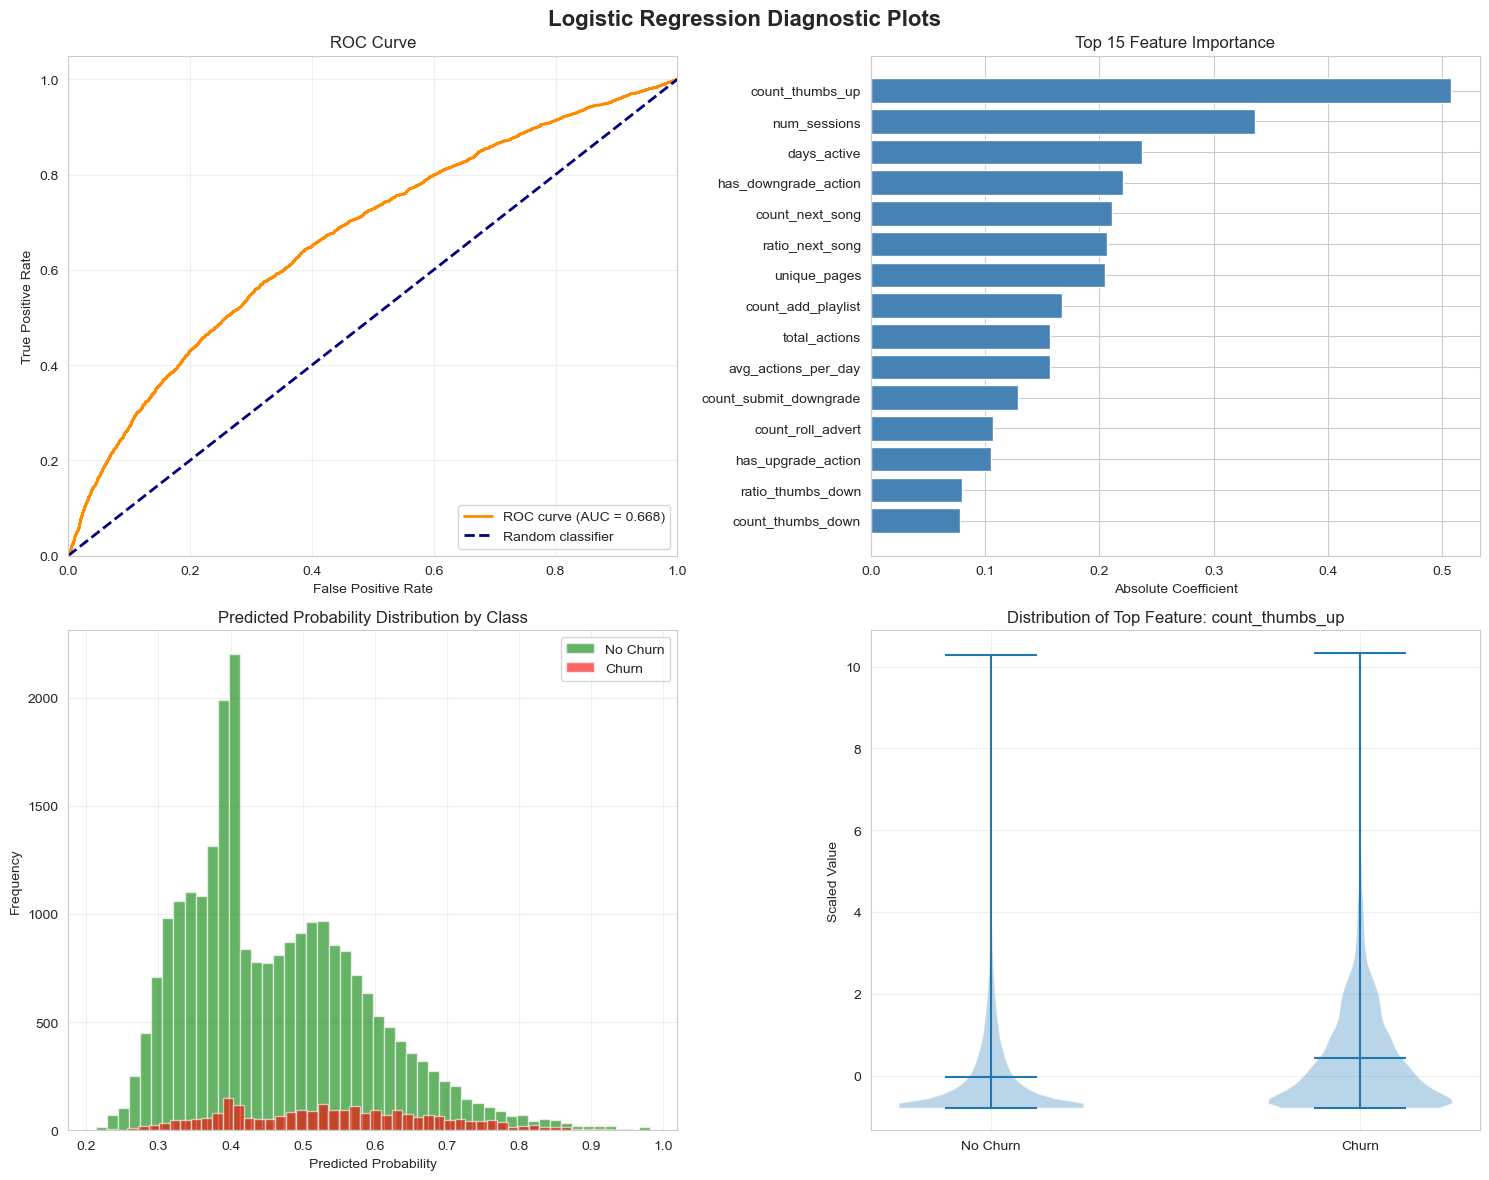

In [ ]:
plot_logistic_regression_diagnostics(X)